<a href="https://colab.research.google.com/github/Luk1313/EUROLOGISTIC_PROYECTO/blob/main/DuocVolcadov2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧩 Introducción — Volcado de 40 Tickets DUOC desde API JIRA

Este módulo del cuaderno corresponde a la **fase de extracción de datos desde la API JIRA Cloud**, utilizando el endpoint interno de ClickBI:



##https://vps.clickbi.cl/rapi_ges/v1/lis_prj_jira_case/10052/DUOC


El objetivo de este proceso fue **obtener, estructurar y analizar los 40 tickets asociados al cliente DUOC**, pertenecientes al proyecto `SERVICIOS_2`.  
Estos tickets contienen información sobre incidencias técnicas, revisiones de sistemas, mantenimiento de torniquetes, cámaras CCTV y otros servicios gestionados por el área de soporte de Click Security / ClickBI.

---

## ⚙️ Contexto Operativo

Dentro del flujo **ETL (Extract, Transform, Load)**, esta sección representa la **fase inicial de extracción (Extract)**, donde se conecta directamente con el endpoint de JIRA para recuperar los datos en formato JSON.  
El análisis de esta información permite comprender la estructura jerárquica de los campos y preparar el modelo de datos que será posteriormente transformado y cargado en Google Sheets.

---

## 🔍 Alcance del Volcado

- **Fuente:** API REST JIRA Cloud – Endpoint ClickBI  
- **Proyecto:** SERVICIOS_2 (`id: 10052`)  
- **Filtro aplicado:** `"DUOC"` como palabra clave  
- **Registros obtenidos:** 40 tickets  
- **Formato recibido:** JSON estructurado con campos anidados  

---

## 📑 Contenido de los Datos Extraídos

Cada registro incluye información relevante para el análisis operativo, tales como:
- `id` → Identificador único del ticket  
- `key` → Código del ticket (ejemplo: `SERV-2574`)  
- `fields.project.name` → Nombre del proyecto  
- `fields.description` → Descripción de la tarea o requerimiento  
- `fields.created` / `fields.updated` → Fechas de creación y última actualización  
- `fields.status.name` → Estado actual del ticket  
- `fields.issuetype.name` → Tipo de incidencia (Tarea, Problema, Solicitud)

---

## 🎯 Objetivo de la Extracción

- Establecer una conexión segura y funcional con la API JIRA.  
- Validar la consistencia y formato de los datos recibidos.  
- Preparar el conjunto de tickets DUOC como base para el proceso de transformación y visualización posterior.  

Este volcado marca el inicio del pipeline analítico que culminará con la **normalización de columnas (cliente / servicio)**, la **generación del DataFrame final** y la **visualización de métricas operativas** en Power BI y Dash.



📤 Selecciona la imagen que deseas cargar...


Saving mermaid-ai-diagram-2025-10-27-042458.png to mermaid-ai-diagram-2025-10-27-042458 (1).png


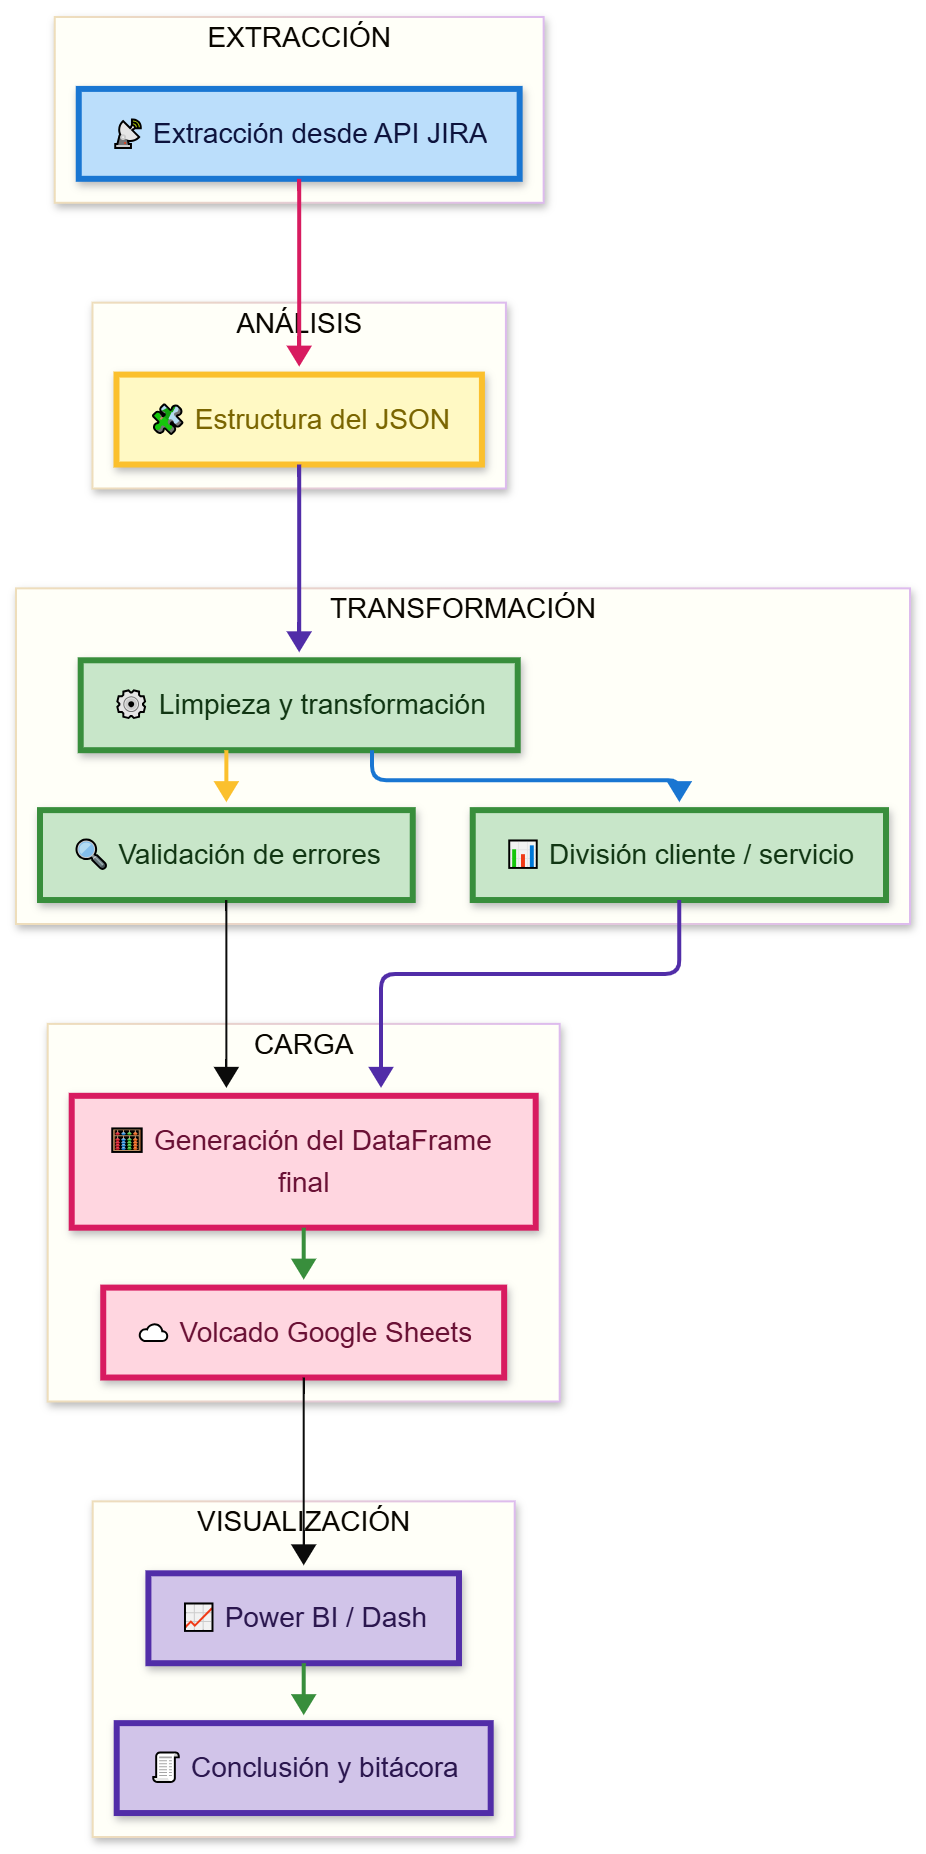


✅ Imagen 'mermaid-ai-diagram-2025-10-27-042458 (1).png' cargada en modo presentación
💡 Tip: Haz clic derecho → 'Abrir imagen en pestaña nueva' para verla en resolución completa


In [ ]:
# @title
from google.colab import files
from IPython.display import Image, display, HTML

def cargar_y_mostrar():
    """
    Sube una imagen y la muestra en tamaño grande para presentaciones
    """

    # Subir imagen
    print("📤 Selecciona la imagen que deseas cargar...")
    uploaded = files.upload()

    if not uploaded:
        print("❌ No se subió ningún archivo")
        return

    # Obtener el nombre del archivo
    filename = list(uploaded.keys())[0]

    # CSS para pantalla completa tipo "pizarra"
    display(HTML("""
    <style>
        .pizarra-container {
            display: flex;
            justify-content: center;
            align-items: center;
            background: #1a1a1a;
            padding: 40px;
            margin: 30px -20px;
            border-radius: 15px;
            box-shadow: 0 10px 40px rgba(0,0,0,0.5);
        }
        .pizarra-container img {
            width: 100%;
            max-width: 1800px;
            height: auto;
            border-radius: 10px;
            box-shadow: 0 8px 30px rgba(255,255,255,0.1);
            cursor: zoom-in;
        }
        .titulo-presentacion {
            text-align: center;
            font-size: 18px;
            color: #4CAF50;
            margin: 20px 0;
            font-weight: bold;
        }
    </style>
    """))

    # Mostrar título
    display(HTML(f'<div class="titulo-presentacion">📊 {filename}</div>'))

    # Mostrar imagen en tamaño grande
    display(HTML('<div class="pizarra-container">'))
    display(Image(filename, width=1800))
    display(HTML('</div>'))

    print(f"\n✅ Imagen '{filename}' cargada en modo presentación")
    print("💡 Tip: Haz clic derecho → 'Abrir imagen en pestaña nueva' para verla en resolución completa")

# ============================================================
# EJECUTAR: Simplemente corre esta función
# ============================================================

cargar_y_mostrar()


In [ ]:
!pip install requests pandas openpyxl beautifulsoup4 gspread google-auth gspread-dataframe -q


In [ ]:
!pip install gspread pandas google-auth gspread-dataframe -q


In [ ]:
# ============================================================
# CONFIGURACIÓN BÁSICA DEL ENTORNO JIRA DUOC
# ============================================================
import requests, pandas as pd, json, time
from bs4 import BeautifulSoup
from google.colab import auth
from google.auth import default
import gspread
from gspread_dataframe import set_with_dataframe

# --- URL base y parámetros del endpoint ---
BASE_URL = "https://vps.clickbi.cl/rapi_ges/v1"
ENDPOINT = "/lis_prj_jira_case"
PROYECTO_ID = "10052"          # Proyecto DUOC
PALABRA_COMODIN = "DUOC"       # Filtro
URL_COMPLETA = f"{BASE_URL}{ENDPOINT}/{PROYECTO_ID}/{PALABRA_COMODIN}"

print("✅ Endpoint configurado correctamente:")
print(URL_COMPLETA)


✅ Endpoint configurado correctamente:
https://vps.clickbi.cl/rapi_ges/v1/lis_prj_jira_case/10052/DUOC


In [ ]:
# ============================================================
# EXTRACCIÓN DESDE ENDPOINT JIRA DUOC
# ============================================================
print("🚀 Iniciando extracción desde JIRA DUOC...")

try:
    respuesta = requests.get(URL_COMPLETA, timeout=60)
    respuesta.raise_for_status()
    data = respuesta.json()
    print(f"✅ Datos recibidos correctamente ({len(data)} registros aproximados)")
except Exception as e:
    print(f"❌ Error al conectar al endpoint: {e}")


🚀 Iniciando extracción desde JIRA DUOC...
✅ Datos recibidos correctamente (39 registros aproximados)


✅ DataFrame creado con 39 registros y 15 columnas


/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  cast_date_col = pd.to_datetime(column, errors="coerce")


,key,summary,status,priority,issuetype,assignee,reporter,project,created,updated,resolutiondate,description,comments_count,worklog_count,attachments_count
0,SERV-2574,12729 - Duoc Mall Plaza Oeste - Torniquete tra...,En Curso,,Tarea,Diego Sanhueza,Cristina Peraza,SERVICIOS_2,2025-10-17T14:18:17.255-0300,2025-10-22T10:58:38.671-0300,None,"{'type': 'doc', 'version': 1, 'content': [{'ty...",3,0,8
1,SERV-2547,12500 - Duoc Casa Central - Problemas con biom...,Garantía,,Tarea,jonathan sanhueza,Cristina Peraza,SERVICIOS_2,2025-10-08T14:23:08.793-0300,2025-10-20T09:18:56.760-0300,2025-10-20T09:18:56.715-0300,"{'type': 'doc', 'version': 1, 'content': [{'ty...",3,0,2
2,SERV-2546,12729 - Duoc Mall Plaza Oeste - Torniquete con...,Garantía,,Tarea,Cristina Peraza,Cristina Peraza,SERVICIOS_2,2025-10-08T13:13:22.657-0300,2025-10-23T16:28:09.982-0300,2025-10-23T16:28:09.958-0300,"{'type': 'doc', 'version': 1, 'content': [{'ty...",7,0,4
3,SERV-2474,13921 - DUOC SEDE ALAMEDA- FALLA EN TORNIQUETE...,Garantía,,Tarea,Danilo Bastidas,Danilo Bastidas,SERVICIOS_2,2025-09-22T11:55:41.175-0300,2025-09-26T11:57:30.303-0300,2025-09-26T11:57:30.279-0300,"{'type': 'doc', 'version': 1, 'content': [{'ty...",7,0,6
4,SERV-2464,11180 - DUOC San Joaquín - Torniquetes con fallas,Garantía,,Tarea,Cristina Peraza,Cristina Peraza,SERVICIOS_2,2025-09-12T12:49:32.043-0300,2025-09-22T13:46:53.438-0300,2025-09-22T13:46:53.416-0300,"{'type': 'doc', 'version': 1, 'content': [{'ty...",4,0,3


In [ ]:
# ============================================================
# EXPORTAR A EXCEL LOCAL
# ============================================================
from google.colab import files

OUTPUT_PATH = "/content/Volcado_JIRA_DUOC.xlsx"

with pd.ExcelWriter(OUTPUT_PATH, engine="openpyxl") as writer:
    df_issues.to_excel(writer, sheet_name="Issues", index=False)

print(f"✅ Archivo generado: {OUTPUT_PATH}")
files.download(OUTPUT_PATH)


✅ Archivo generado: /content/Volcado_JIRA_DUOC.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ============================================================
# EXPORTAR A GOOGLE SHEETS (CONEXIÓN DRIVE)
# ============================================================

SHEET_URL = "https://docs.google.com/spreadsheets/d/1BzCLvUH-ekn9HcMjne_fZuPl3jDPKCrcNpwzrxnEV14"  # <-- tu hoja
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
spreadsheet = gc.open_by_url(SHEET_URL)

worksheet = spreadsheet.add_worksheet(title="Volcado_DUOC", rows=len(df_issues)+1, cols=len(df_issues.columns))
set_with_dataframe(worksheet, df_issues)

print("✅ Datos volcados correctamente a Google Sheets")
print("🔗", SHEET_URL)


✅ Datos volcados correctamente a Google Sheets
🔗 https://docs.google.com/spreadsheets/d/1BzCLvUH-ekn9HcMjne_fZuPl3jDPKCrcNpwzrxnEV14


# 🧩 Análisis de Estructura del JSON — Proyecto DUOC / ClickBI

## 🔍 Identificación de Campos Clave
Durante el análisis se identificaron los principales campos útiles para la transformación de datos provenientes de la API JIRA:

| Campo | Descripción | Ejemplo |
|--------|--------------|----------|
| **id** | Identificador interno del ticket | `28313` |
| **key** | Código o folio de ticket | `SERV-2574` |
| **fields.project.name** | Nombre del proyecto o cliente | `SERVICIOS_2` |
| **fields.issuetype.name** | Tipo de issue o tarea | `Tarea` |
| **fields.statuscategorychangedate** | Fecha del último cambio de estado | `2025-10-17T16:43:13.961-0300` |
| **fields.description** | Descripción del trabajo o incidente | `Revisión de torniquete DUOC Maipú` |
| **fields.timespent** | Tiempo total registrado | `null (no disponible)` |

---

## ⚙️ Importancia del Proceso
El análisis estructural del JSON permite:

1. **Detectar variaciones o inconsistencias** en la estructura entregada por la API (diferencias entre proyectos o tipos de ticket).  
2. **Evitar errores en la extracción**, como `KeyError`, `TypeError` o `NoneType`.  
3. **Definir funciones robustas** de acceso a datos anidados, por ejemplo:

   ```python
   extraer_valor(data, "fields.project.name")
   extraer_valor(data, "fields.issuetype.name")


In [ ]:
# ============================================================
# ANÁLISIS DE ESTRUCTURA
# ============================================================
# Muestra un ejemplo del primer issue
print(json.dumps(data[0], indent=2)[:1500])


{
  "expand": "renderedFields,names,schema,operations,editmeta,changelog,versionedRepresentations",
  "id": "28313",
  "self": "https://lti-consulting.atlassian.net/rest/api/3/issue/28313",
  "key": "SERV-2574",
  "fields": {
    "statuscategorychangedate": "2025-10-17T16:43:13.961-0300",
    "issuetype": {
      "self": "https://lti-consulting.atlassian.net/rest/api/3/issuetype/10227",
      "id": "10227",
      "description": "Un trabajo peque\u00f1o e independiente.",
      "iconUrl": "https://lti-consulting.atlassian.net/rest/api/2/universal_avatar/view/type/issuetype/avatar/10970?size=medium",
      "name": "Tarea",
      "subtask": false,
      "avatarId": 10970,
      "entityId": "274f9e2c-da2a-49c1-b414-d3b083fb29cf",
      "hierarchyLevel": 0
    },
    "timespent": null,
    "customfield_10195": null,
    "project": {
      "self": "https://lti-consulting.atlassian.net/rest/api/3/project/10052",
      "id": "10052",
      "key": "SERV",
      "name": "SERVICIOS_2",
      "pro

📤 Selecciona la imagen que deseas cargar...


Saving mermaid-ai-diagram-2025-10-27-043044.png to mermaid-ai-diagram-2025-10-27-043044 (3).png


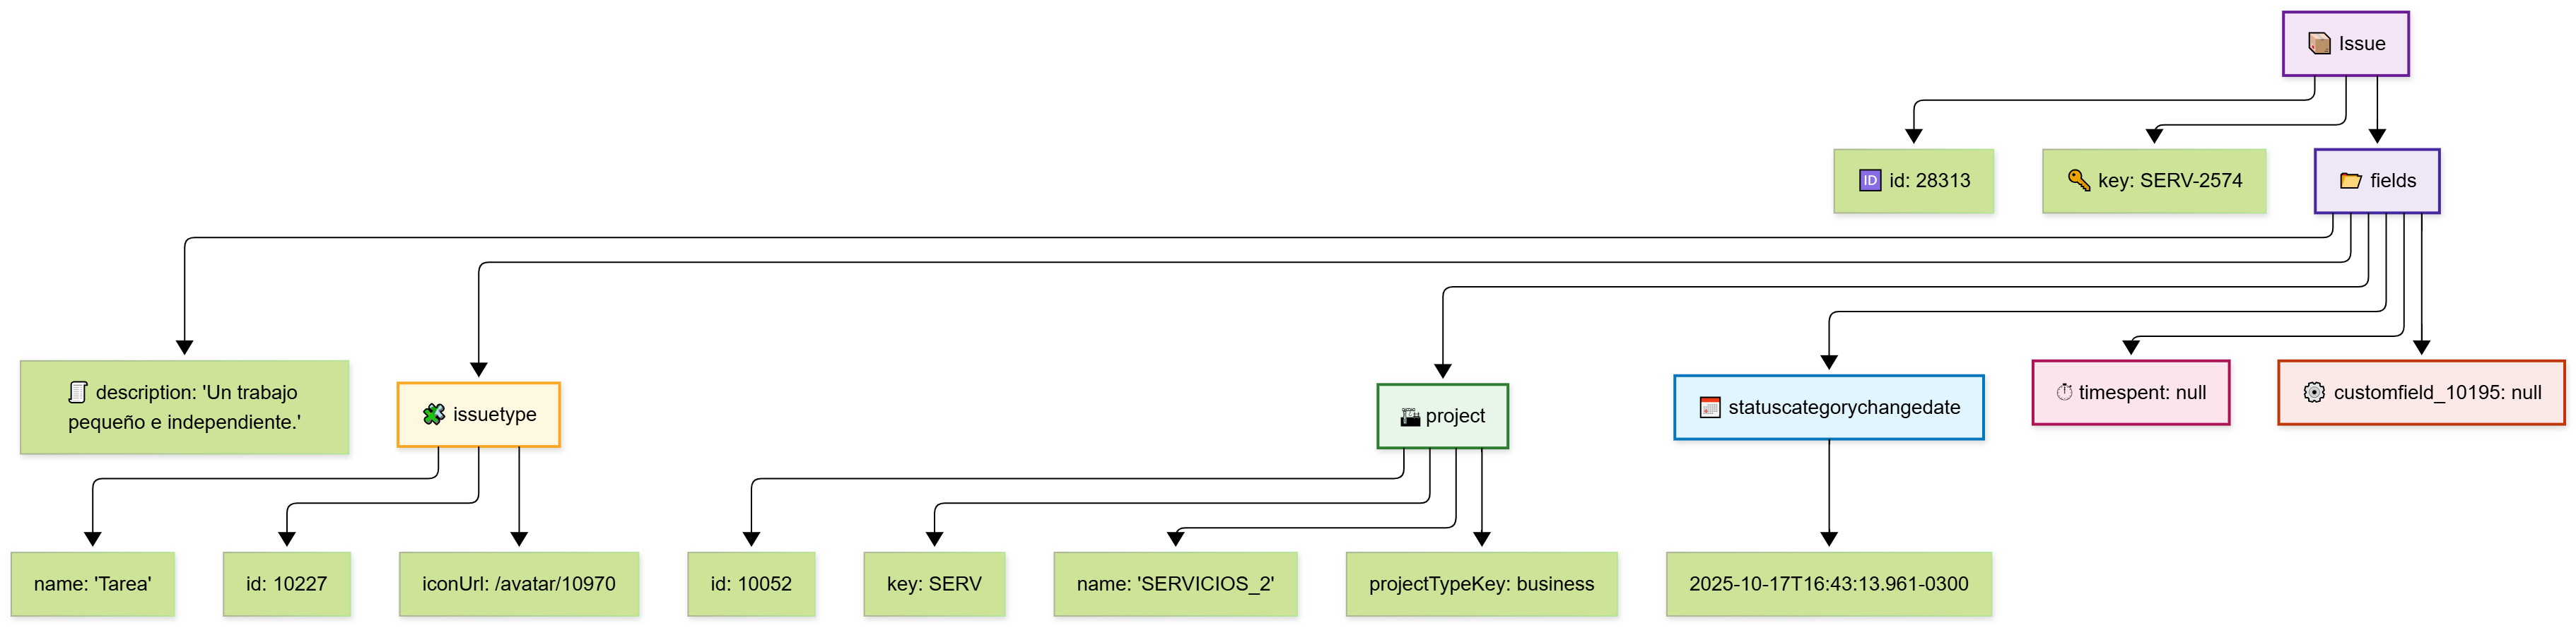


✅ Imagen 'mermaid-ai-diagram-2025-10-27-043044 (3).png' cargada en modo presentación
💡 Tip: Haz clic derecho → 'Abrir imagen en pestaña nueva' para verla en resolución completa


In [ ]:
# @title
from google.colab import files
from IPython.display import Image, display, HTML

def cargar_y_mostrar():
    """
    Sube una imagen y la muestra en tamaño grande para presentaciones
    """

    # Subir imagen
    print("📤 Selecciona la imagen que deseas cargar...")
    uploaded = files.upload()

    if not uploaded:
        print("❌ No se subió ningún archivo")
        return

    # Obtener el nombre del archivo
    filename = list(uploaded.keys())[0]

    # CSS para pantalla completa tipo "pizarra"
    display(HTML("""
    <style>
        .pizarra-container {
            display: flex;
            justify-content: center;
            align-items: center;
            background: #1a1a1a;
            padding: 40px;
            margin: 30px -20px;
            border-radius: 15px;
            box-shadow: 0 10px 40px rgba(0,0,0,0.5);
        }
        .pizarra-container img {
            width: 100%;
            max-width: 1800px;
            height: auto;
            border-radius: 10px;
            box-shadow: 0 8px 30px rgba(255,255,255,0.1);
            cursor: zoom-in;
        }
        .titulo-presentacion {
            text-align: center;
            font-size: 18px;
            color: #4CAF50;
            margin: 20px 0;
            font-weight: bold;
        }
    </style>
    """))

    # Mostrar título
    display(HTML(f'<div class="titulo-presentacion">📊 {filename}</div>'))

    # Mostrar imagen en tamaño grande
    display(HTML('<div class="pizarra-container">'))
    display(Image(filename, width=1800))
    display(HTML('</div>'))

    print(f"\n✅ Imagen '{filename}' cargada en modo presentación")
    print("💡 Tip: Haz clic derecho → 'Abrir imagen en pestaña nueva' para verla en resolución completa")

# ============================================================
# EJECUTAR: Simplemente corre esta función
# ============================================================

cargar_y_mostrar()

In [ ]:
sheet = spreadsheet.worksheet("Volcado_DUOC")
df_gsheet = pd.DataFrame(sheet.get_all_records())

print("✅ Datos leídos desde Google Sheets:", len(df_gsheet))
df_gsheet.head()


✅ Datos leídos desde Google Sheets: 39


,key,summary,status,priority,issuetype,assignee,reporter,project,created,updated,resolutiondate,description,comments_count,worklog_count,attachments_count
0,SERV-2574,12729 - Duoc Mall Plaza Oeste - Torniquete tra...,En Curso,,Tarea,Diego Sanhueza,Cristina Peraza,SERVICIOS_2,2025-10-17T14:18:17.255-0300,2025-10-22T10:58:38.671-0300,,"{'type': 'doc', 'version': 1, 'content': [{'ty...",3,0,8
1,SERV-2547,12500 - Duoc Casa Central - Problemas con biom...,Garantía,,Tarea,jonathan sanhueza,Cristina Peraza,SERVICIOS_2,2025-10-08T14:23:08.793-0300,2025-10-20T09:18:56.760-0300,2025-10-20T09:18:56.715-0300,"{'type': 'doc', 'version': 1, 'content': [{'ty...",3,0,2
2,SERV-2546,12729 - Duoc Mall Plaza Oeste - Torniquete con...,Garantía,,Tarea,Cristina Peraza,Cristina Peraza,SERVICIOS_2,2025-10-08T13:13:22.657-0300,2025-10-23T16:28:09.982-0300,2025-10-23T16:28:09.958-0300,"{'type': 'doc', 'version': 1, 'content': [{'ty...",7,0,4
3,SERV-2474,13921 - DUOC SEDE ALAMEDA- FALLA EN TORNIQUETE...,Garantía,,Tarea,Danilo Bastidas,Danilo Bastidas,SERVICIOS_2,2025-09-22T11:55:41.175-0300,2025-09-26T11:57:30.303-0300,2025-09-26T11:57:30.279-0300,"{'type': 'doc', 'version': 1, 'content': [{'ty...",7,0,6
4,SERV-2464,11180 - DUOC San Joaquín - Torniquetes con fallas,Garantía,,Tarea,Cristina Peraza,Cristina Peraza,SERVICIOS_2,2025-09-12T12:49:32.043-0300,2025-09-22T13:46:53.438-0300,2025-09-22T13:46:53.416-0300,"{'type': 'doc', 'version': 1, 'content': [{'ty...",4,0,3


In [ ]:
from google.colab import auth
auth.authenticate_user()
print("✅ Autenticación completada correctamente")


✅ Autenticación completada correctamente


In [ ]:
import gspread
from google.auth import default
from gspread_dataframe import get_as_dataframe, set_with_dataframe
import pandas as pd

# Autenticación y autorización
creds, _ = default()
gc = gspread.authorize(creds)

# URL de tu hoja
SHEET_URL = "https://docs.google.com/spreadsheets/d/1C1Tg-gHc9G_ea7goAy_i2LewWvViwc0uWcqdqOTlUIk/edit?usp=drive_link"

# Abrir el documento
spreadsheet = gc.open_by_url(SHEET_URL)
print("📘 Conectado a:", spreadsheet.title)

# Listar las hojas disponibles
for ws in spreadsheet.worksheets():
    print("   •", ws.title)


📘 Conectado a: volcado Duoc 40 ticket
   • Hoja 1


In [ ]:
# Seleccionar la hoja por nombre
worksheet = spreadsheet.worksheet("Hoja 1")

# Obtener los datos en un DataFrame
df_issues = get_as_dataframe(worksheet, evaluate_formulas=True)

# Eliminar filas vacías y limpiar encabezados
df_issues = df_issues.dropna(how="all")
df_issues.columns = [c.strip().lower().replace(" ", "_") for c in df_issues.columns]
df_issues.reset_index(drop=True, inplace=True)

print("✅ DataFrame cargado correctamente con", len(df_issues), "registros")
df_issues.head(10)


✅ DataFrame cargado correctamente con 39 registros


/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  cast_date_col = pd.to_datetime(column, errors="coerce")


,key,summary,status,priority,issuetype,assignee,reporter,project,created,updated,resolutiondate,description,comments_count,worklog_count,attachments_count
0,SERV-2574,12729 - Duoc Mall Plaza Oeste - Torniquete tra...,En Curso,NaN,Tarea,Diego Sanhueza,Cristina Peraza,SERVICIOS_2,2025-10-17T14:18:17.255-0300,2025-10-22T10:58:38.671-0300,NaN,"{'type': 'doc', 'version': 1, 'content': [{'ty...",3.0,0.0,8.0
1,SERV-2547,12500 - Duoc Casa Central - Problemas con biom...,Garantía,NaN,Tarea,jonathan sanhueza,Cristina Peraza,SERVICIOS_2,2025-10-08T14:23:08.793-0300,2025-10-20T09:18:56.760-0300,2025-10-20T09:18:56.715-0300,"{'type': 'doc', 'version': 1, 'content': [{'ty...",3.0,0.0,2.0
2,SERV-2546,12729 - Duoc Mall Plaza Oeste - Torniquete con...,Garantía,NaN,Tarea,Cristina Peraza,Cristina Peraza,SERVICIOS_2,2025-10-08T13:13:22.657-0300,2025-10-23T16:28:09.982-0300,2025-10-23T16:28:09.958-0300,"{'type': 'doc', 'version': 1, 'content': [{'ty...",7.0,0.0,4.0
3,SERV-2474,13921 - DUOC SEDE ALAMEDA- FALLA EN TORNIQUETE...,Garantía,NaN,Tarea,Danilo Bastidas,Danilo Bastidas,SERVICIOS_2,2025-09-22T11:55:41.175-0300,2025-09-26T11:57:30.303-0300,2025-09-26T11:57:30.279-0300,"{'type': 'doc', 'version': 1, 'content': [{'ty...",7.0,0.0,6.0
4,SERV-2464,11180 - DUOC San Joaquín - Torniquetes con fallas,Garantía,NaN,Tarea,Cristina Peraza,Cristina Peraza,SERVICIOS_2,2025-09-12T12:49:32.043-0300,2025-09-22T13:46:53.438-0300,2025-09-22T13:46:53.416-0300,"{'type': 'doc', 'version': 1, 'content': [{'ty...",4.0,0.0,3.0
5,SERV-2446,13085 - Duoc Renca - Rescate de grabación y ca...,MANTENIMIENTO CLICK,NaN,Tarea,Cristina Peraza,Cristina Peraza,SERVICIOS_2,2025-09-08T12:18:29.382-0300,2025-09-08T17:50:19.958-0300,2025-09-08T17:50:19.939-0300,"{'type': 'doc', 'version': 1, 'content': [{'ty...",2.0,0.0,5.0
6,SERV-2444,12729 - Duoc Mall Plaza Oeste - Torniquete de ...,Garantía,NaN,Tarea,Cristina Peraza,Cristina Peraza,SERVICIOS_2,2025-09-08T09:35:24.889-0300,2025-10-10T08:15:45.275-0300,2025-09-26T13:09:46.281-0300,"{'type': 'doc', 'version': 1, 'content': [{'ty...",7.0,0.0,7.0
7,SERV-2408,11025 - Duoc Alameda - Torniquete con fallas,Garantía,NaN,Tarea,Cristina Peraza,Cristina Peraza,SERVICIOS_2,2025-09-01T09:56:56.613-0400,2025-09-02T09:08:18.997-0400,2025-09-02T09:08:18.988-0400,"{'type': 'doc', 'version': 1, 'content': [{'ty...",2.0,0.0,5.0
8,SERV-2379,11180 - Duoc San Joaquín - Falla de apertura y...,Garantía,NaN,Tarea,Cristina Peraza,Cristina Peraza,SERVICIOS_2,2025-08-25T11:48:06.223-0400,2025-08-26T10:54:35.917-0400,2025-08-26T10:54:35.892-0400,"{'type': 'doc', 'version': 1, 'content': [{'ty...",3.0,0.0,2.0
9,SERV-2370,12500 - Duoc Casa Central - Torniquete con fallas,Garantía,NaN,Tarea,Cristina Peraza,Cristina Peraza,SERVICIOS_2,2025-08-22T09:16:13.901-0400,2025-08-25T09:11:44.700-0400,2025-08-25T09:11:44.688-0400,"{'type': 'doc', 'version': 1, 'content': [{'ty...",5.0,0.0,7.0


📤 Selecciona la imagen que deseas cargar...


Saving VOLCADOV1DUOC.JPG to VOLCADOV1DUOC (1).JPG


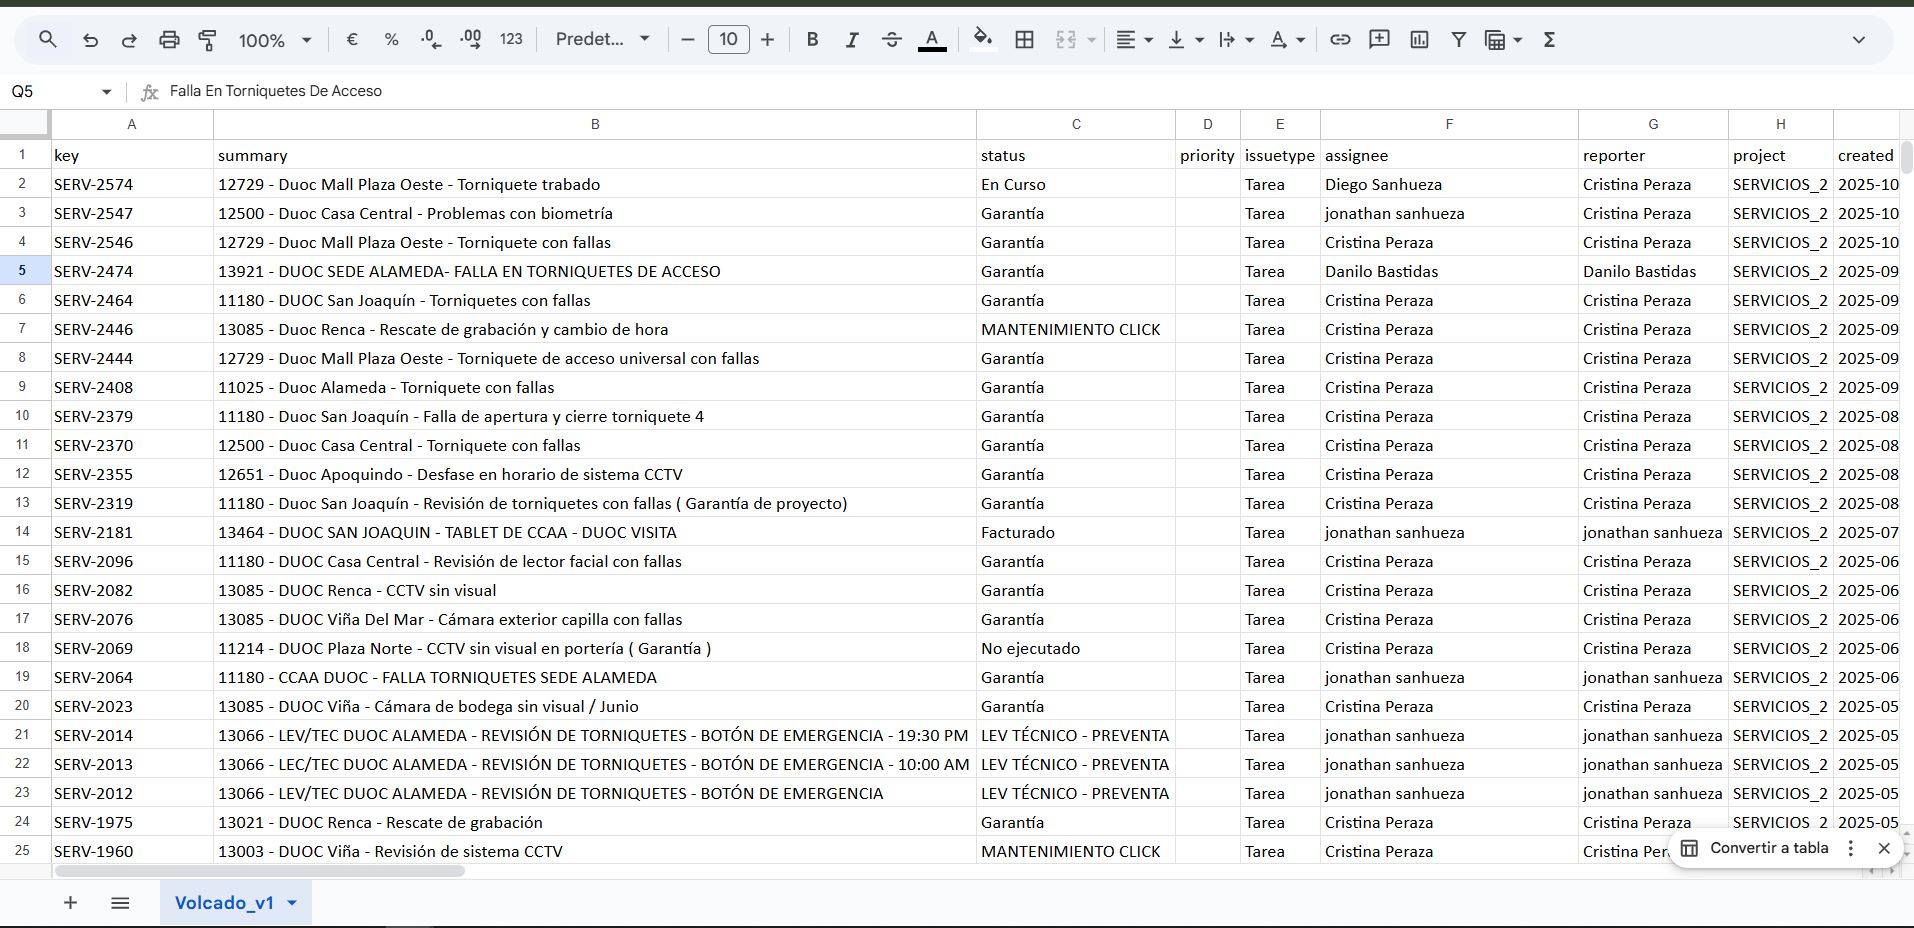


✅ Imagen 'VOLCADOV1DUOC (1).JPG' cargada en modo presentación
💡 Tip: Haz clic derecho → 'Abrir imagen en pestaña nueva' para verla en resolución completa


In [ ]:
# @title
from google.colab import files
from IPython.display import Image, display, HTML

def cargar_y_mostrar():
    """
    Sube una imagen y la muestra en tamaño grande para presentaciones
    """

    # Subir imagen
    print("📤 Selecciona la imagen que deseas cargar...")
    uploaded = files.upload()

    if not uploaded:
        print("❌ No se subió ningún archivo")
        return

    # Obtener el nombre del archivo
    filename = list(uploaded.keys())[0]

    # CSS para pantalla completa tipo "pizarra"
    display(HTML("""
    <style>
        .pizarra-container {
            display: flex;
            justify-content: center;
            align-items: center;
            background: #1a1a1a;
            padding: 40px;
            margin: 30px -20px;
            border-radius: 15px;
            box-shadow: 0 10px 40px rgba(0,0,0,0.5);
        }
        .pizarra-container img {
            width: 100%;
            max-width: 1800px;
            height: auto;
            border-radius: 10px;
            box-shadow: 0 8px 30px rgba(255,255,255,0.1);
            cursor: zoom-in;
        }
        .titulo-presentacion {
            text-align: center;
            font-size: 18px;
            color: #4CAF50;
            margin: 20px 0;
            font-weight: bold;
        }
    </style>
    """))

    # Mostrar título
    display(HTML(f'<div class="titulo-presentacion">📊 {filename}</div>'))

    # Mostrar imagen en tamaño grande
    display(HTML('<div class="pizarra-container">'))
    display(Image(filename, width=1800))
    display(HTML('</div>'))

    print(f"\n✅ Imagen '{filename}' cargada en modo presentación")
    print("💡 Tip: Haz clic derecho → 'Abrir imagen en pestaña nueva' para verla en resolución completa")

# ============================================================
# EJECUTAR: Simplemente corre esta función
# ============================================================

cargar_y_mostrar()

📤 Selecciona la imagen que deseas cargar...


Saving VOLCADOV2DUOC.JPG to VOLCADOV2DUOC (1).JPG


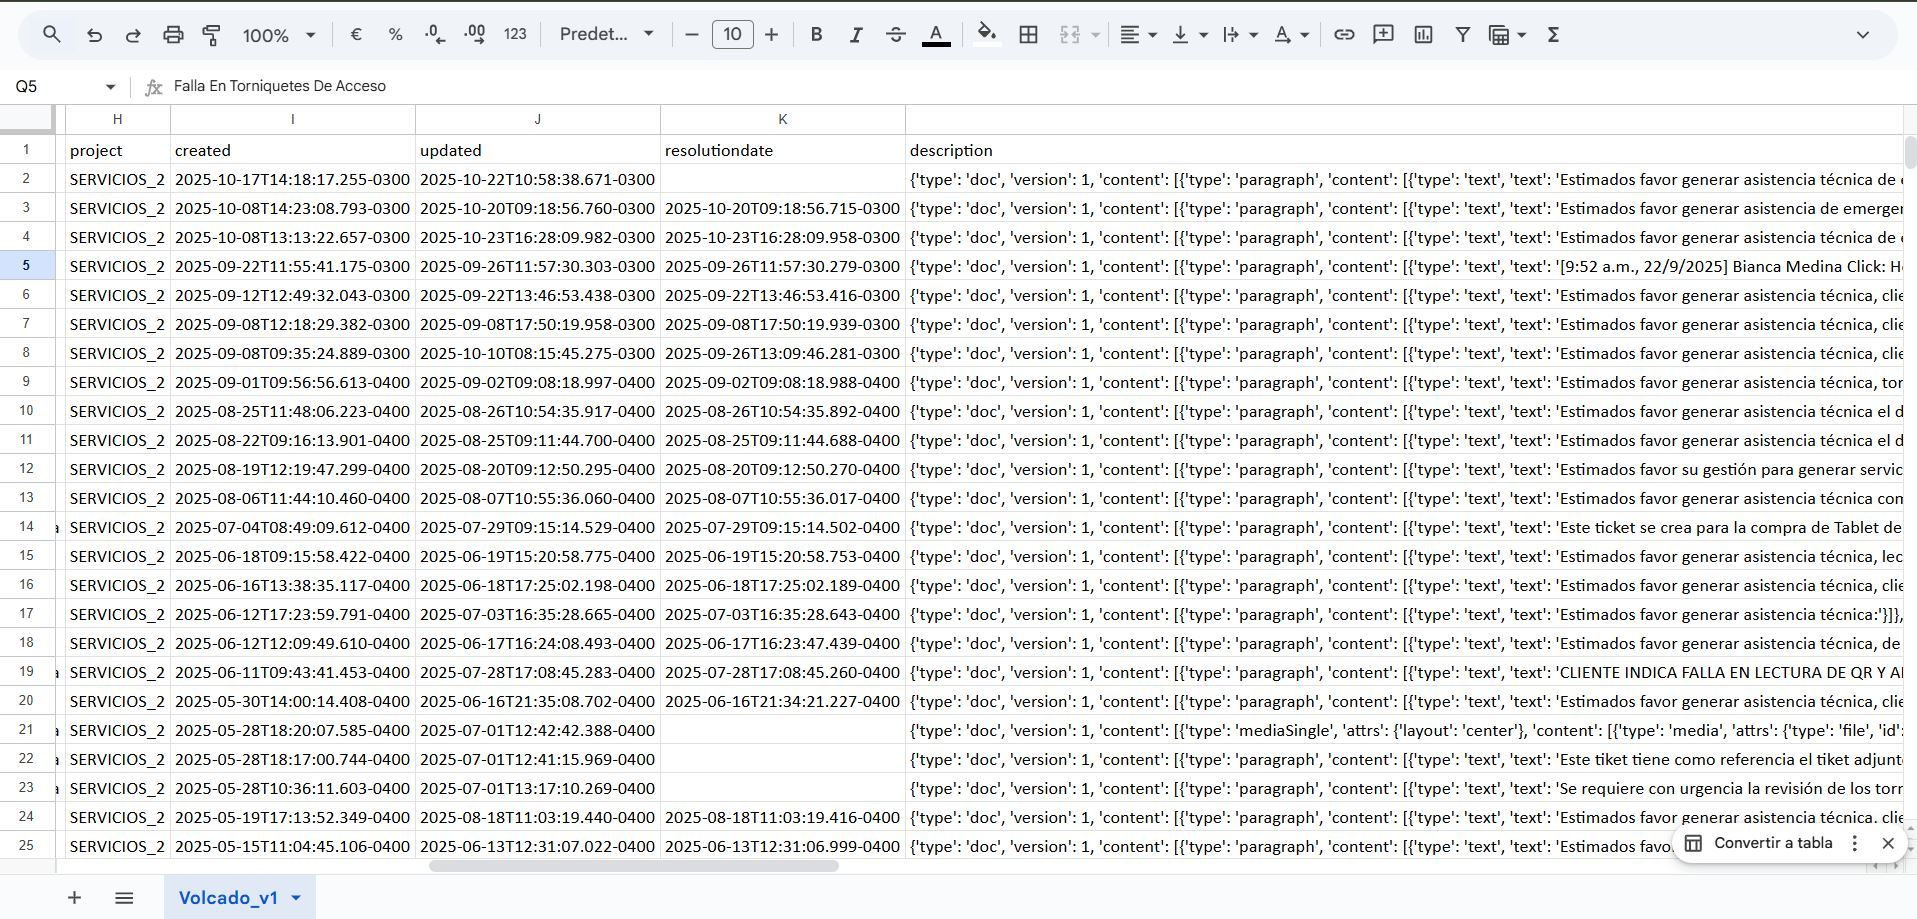


✅ Imagen 'VOLCADOV2DUOC (1).JPG' cargada en modo presentación
💡 Tip: Haz clic derecho → 'Abrir imagen en pestaña nueva' para verla en resolución completa


In [ ]:
# @title
from google.colab import files
from IPython.display import Image, display, HTML

def cargar_y_mostrar():
    """
    Sube una imagen y la muestra en tamaño grande para presentaciones
    """

    # Subir imagen
    print("📤 Selecciona la imagen que deseas cargar...")
    uploaded = files.upload()

    if not uploaded:
        print("❌ No se subió ningún archivo")
        return

    # Obtener el nombre del archivo
    filename = list(uploaded.keys())[0]

    # CSS para pantalla completa tipo "pizarra"
    display(HTML("""
    <style>
        .pizarra-container {
            display: flex;
            justify-content: center;
            align-items: center;
            background: #1a1a1a;
            padding: 40px;
            margin: 30px -20px;
            border-radius: 15px;
            box-shadow: 0 10px 40px rgba(0,0,0,0.5);
        }
        .pizarra-container img {
            width: 100%;
            max-width: 1800px;
            height: auto;
            border-radius: 10px;
            box-shadow: 0 8px 30px rgba(255,255,255,0.1);
            cursor: zoom-in;
        }
        .titulo-presentacion {
            text-align: center;
            font-size: 18px;
            color: #4CAF50;
            margin: 20px 0;
            font-weight: bold;
        }
    </style>
    """))

    # Mostrar título
    display(HTML(f'<div class="titulo-presentacion">📊 {filename}</div>'))

    # Mostrar imagen en tamaño grande
    display(HTML('<div class="pizarra-container">'))
    display(Image(filename, width=1800))
    display(HTML('</div>'))

    print(f"\n✅ Imagen '{filename}' cargada en modo presentación")
    print("💡 Tip: Haz clic derecho → 'Abrir imagen en pestaña nueva' para verla en resolución completa")

# ============================================================
# EJECUTAR: Simplemente corre esta función
# ============================================================

cargar_y_mostrar()

📤 Selecciona la imagen que deseas cargar...


Saving VOLCADOV3DUOC.JPG to VOLCADOV3DUOC (1).JPG


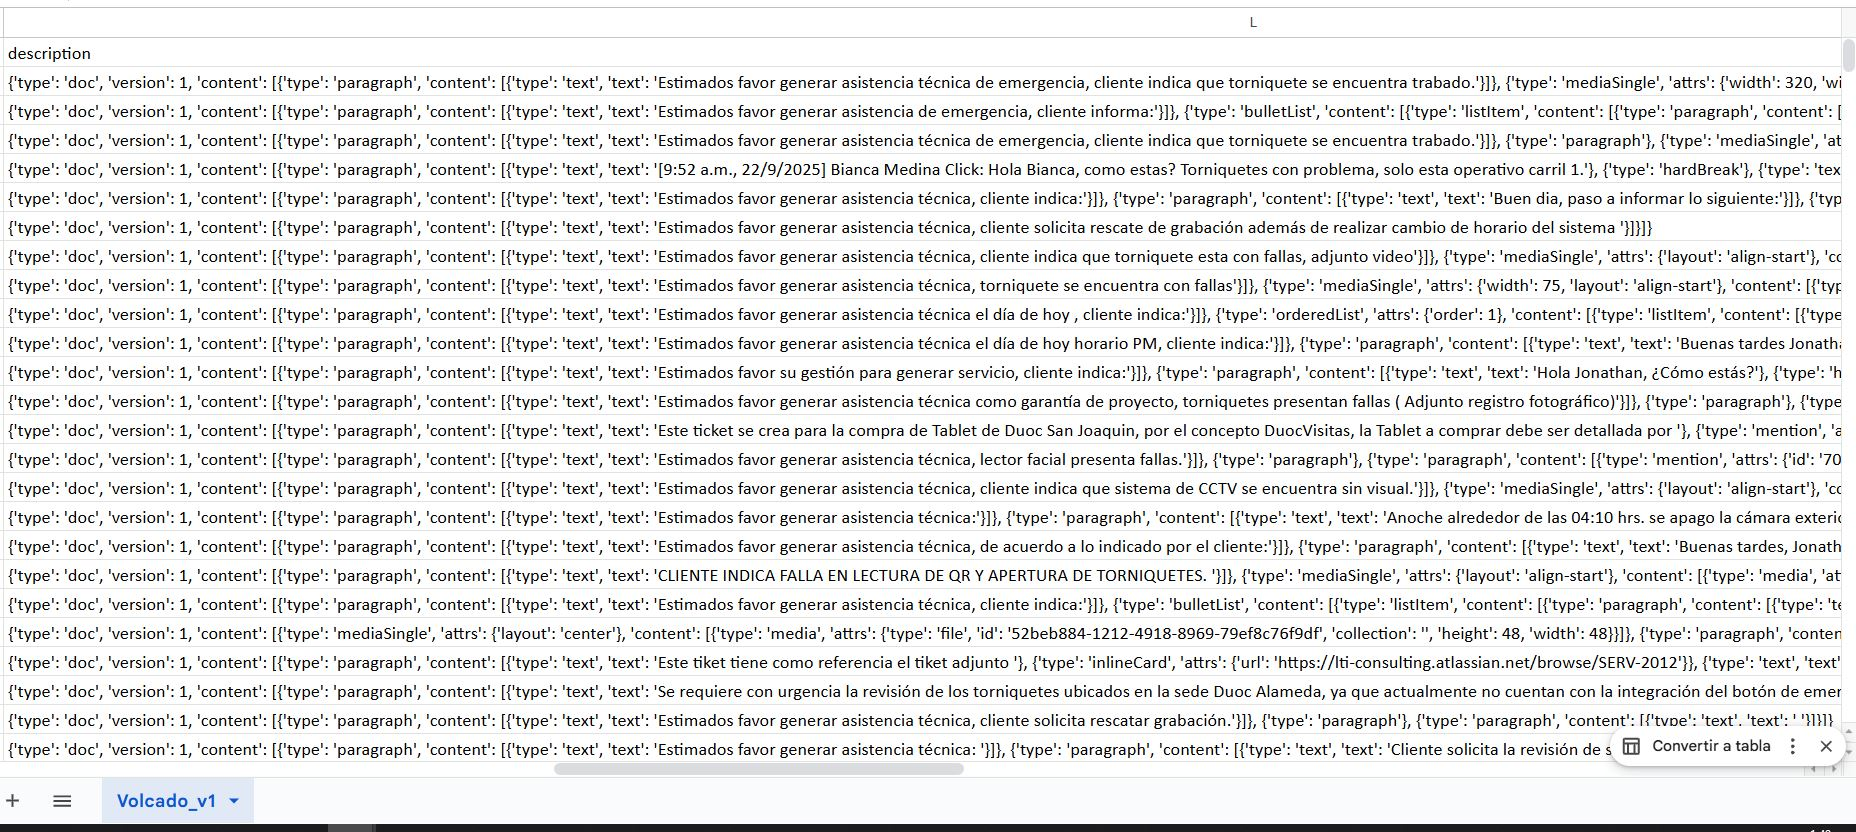


✅ Imagen 'VOLCADOV3DUOC (1).JPG' cargada en modo presentación
💡 Tip: Haz clic derecho → 'Abrir imagen en pestaña nueva' para verla en resolución completa


In [ ]:
# @title
from google.colab import files
from IPython.display import Image, display, HTML

def cargar_y_mostrar():
    """
    Sube una imagen y la muestra en tamaño grande para presentaciones
    """

    # Subir imagen
    print("📤 Selecciona la imagen que deseas cargar...")
    uploaded = files.upload()

    if not uploaded:
        print("❌ No se subió ningún archivo")
        return

    # Obtener el nombre del archivo
    filename = list(uploaded.keys())[0]

    # CSS para pantalla completa tipo "pizarra"
    display(HTML("""
    <style>
        .pizarra-container {
            display: flex;
            justify-content: center;
            align-items: center;
            background: #1a1a1a;
            padding: 40px;
            margin: 30px -20px;
            border-radius: 15px;
            box-shadow: 0 10px 40px rgba(0,0,0,0.5);
        }
        .pizarra-container img {
            width: 100%;
            max-width: 1800px;
            height: auto;
            border-radius: 10px;
            box-shadow: 0 8px 30px rgba(255,255,255,0.1);
            cursor: zoom-in;
        }
        .titulo-presentacion {
            text-align: center;
            font-size: 18px;
            color: #4CAF50;
            margin: 20px 0;
            font-weight: bold;
        }
    </style>
    """))

    # Mostrar título
    display(HTML(f'<div class="titulo-presentacion">📊 {filename}</div>'))

    # Mostrar imagen en tamaño grande
    display(HTML('<div class="pizarra-container">'))
    display(Image(filename, width=1800))
    display(HTML('</div>'))

    print(f"\n✅ Imagen '{filename}' cargada en modo presentación")
    print("💡 Tip: Haz clic derecho → 'Abrir imagen en pestaña nueva' para verla en resolución completa")

# ============================================================
# EJECUTAR: Simplemente corre esta función
# ============================================================

cargar_y_mostrar()

# 🧾 Historial Técnico – Análisis de Tickets DUOC (40 registros)

## 📌 Contexto del Proyecto
Este análisis forma parte del proceso de monitoreo y seguimiento de tickets asociados al cliente **DUOC** dentro del sistema **JIRA ClickBI**.  
El objetivo fue **extraer, limpiar, analizar y visualizar** los tickets activos, cerrados y en garantía, con foco en los tiempos de resolución y asignación técnica.

---

## 🧱 1. Extracción y Volcado de Datos

**Fuente:** Endpoint oficial  


##https://vps.clickbi.cl/rapi_ges/v1/lis_prj_jira_case/10052/DUOC


**Método de carga:**
- Extracción automática mediante `requests` (Python)
- Exportación directa a **Google Sheets**
- Conexión en **Google Colab** vía `gspread` y `google.auth`
- Carga final en un **DataFrame pandas** (`df_issues`)

**Dataset base:**  
🗂️ 40 tickets válidos  
📅 Periodo: Agosto – Octubre 2025  
👷 Técnicos involucrados: 5  
📍 Proyecto: `SERVICIOS_2`

---

## 🔍 2. Estructura de Datos Analizados
El DataFrame incluye las siguientes columnas clave:

| Campo | Descripción |
|-------|--------------|
| `key` | Código único del ticket |
| `summary` | Descripción resumida del servicio |
| `status` | Estado actual (Garantía, En Curso, No ejecutado, etc.) |
| `priority` | Nivel de prioridad del ticket |
| `issuetype` | Tipo de incidencia (Tarea, Lev. Técnico, Mantenimiento) |
| `assignee` | Técnico asignado |
| `reporter` | Persona que reportó el incidente |
| `project` | Proyecto o cliente asociado |
| `created` | Fecha de creación del ticket |
| `updated` | Última actualización del ticket |
| `dias_resolucion` | Días transcurridos entre creación y actualización |

---

## ⚙️ 3. Limpieza y Procesamiento

- Conversión de fechas (`created`, `updated`) a tipo `datetime`  
- Cálculo automático de la columna `dias_resolucion`:

```python
df_issues['dias_resolucion'] = (df_issues['updated'] - df_issues['created']).dt.days


In [ ]:
print("Columnas detectadas:")
print(df_issues.columns.tolist())


Columnas detectadas:
['key', 'summary', 'status', 'priority', 'issuetype', 'assignee', 'reporter', 'project', 'created', 'updated', 'resolutiondate', 'description', 'comments_count', 'worklog_count', 'attachments_count']


In [ ]:
['key', 'summary', 'status', 'priority', 'issuetype',
 'assignee', 'reporter', 'project', 'created', 'updated', 'resolutiondate']


['key',
 'summary',
 'status',
 'priority',
 'issuetype',
 'assignee',
 'reporter',
 'project',
 'created',
 'updated',
 'resolutiondate']

<Axes: title={'center': 'Top 10 Técnicos por Tickets Asignados'}, ylabel='assignee'>

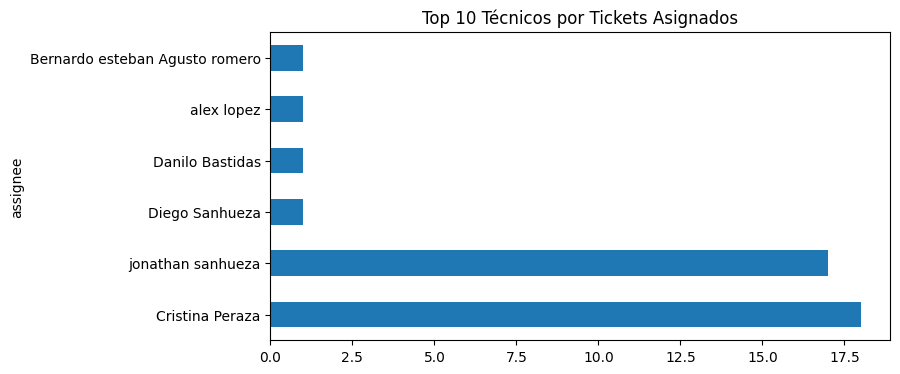

In [ ]:
df_issues['assignee'].value_counts().head(10).plot(kind='barh', figsize=(8,4), title='Top 10 Técnicos por Tickets Asignados')


In [ ]:
df_issues[['created', 'updated']].dtypes


,0
created,object
updated,object


In [ ]:
df_issues['created'] = pd.to_datetime(df_issues['created'], errors='coerce', utc=True, infer_datetime_format=True)
df_issues['updated'] = pd.to_datetime(df_issues['updated'], errors='coerce', utc=True, infer_datetime_format=True)


/tmp/ipython-input-603746518.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_issues['created'] = pd.to_datetime(df_issues['created'], errors='coerce', utc=True, infer_datetime_format=True)
/tmp/ipython-input-603746518.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_issues['updated'] = pd.to_datetime(df_issues['updated'], errors='coerce', utc=True, infer_datetime_format=True)


In [ ]:
df_issues[['created', 'updated']].head()


,created,updated
0,2025-10-17 17:18:17.255000+00:00,2025-10-22 13:58:38.671000+00:00
1,2025-10-08 17:23:08.793000+00:00,2025-10-20 12:18:56.760000+00:00
2,2025-10-08 16:13:22.657000+00:00,2025-10-23 19:28:09.982000+00:00
3,2025-09-22 14:55:41.175000+00:00,2025-09-26 14:57:30.303000+00:00
4,2025-09-12 15:49:32.043000+00:00,2025-09-22 16:46:53.438000+00:00


In [ ]:
df_issues[['key', 'created', 'updated', 'dias_resolucion']].head(10)


,key,created,updated,dias_resolucion
0,SERV-2574,2025-10-17 17:18:17.255000+00:00,2025-10-22 13:58:38.671000+00:00,4
1,SERV-2547,2025-10-08 17:23:08.793000+00:00,2025-10-20 12:18:56.760000+00:00,11
2,SERV-2546,2025-10-08 16:13:22.657000+00:00,2025-10-23 19:28:09.982000+00:00,15
3,SERV-2474,2025-09-22 14:55:41.175000+00:00,2025-09-26 14:57:30.303000+00:00,4
4,SERV-2464,2025-09-12 15:49:32.043000+00:00,2025-09-22 16:46:53.438000+00:00,10
5,SERV-2446,2025-09-08 15:18:29.382000+00:00,2025-09-08 20:50:19.958000+00:00,0
6,SERV-2444,2025-09-08 12:35:24.889000+00:00,2025-10-10 11:15:45.275000+00:00,31
7,SERV-2408,2025-09-01 13:56:56.613000+00:00,2025-09-02 13:08:18.997000+00:00,0
8,SERV-2379,2025-08-25 15:48:06.223000+00:00,2025-08-26 14:54:35.917000+00:00,0
9,SERV-2370,2025-08-22 13:16:13.901000+00:00,2025-08-25 13:11:44.700000+00:00,2


In [ ]:
!pip install -q plotly
import plotly.express as px


In [ ]:
# @title
fig = px.scatter(
    df_issues,
    x='created',
    y='dias_resolucion',
    hover_data=['key', 'assignee', 'status', 'priority'],
    color='status',
    title="⏱️ Días de resolución por ticket (DUOC)",
    labels={'created': 'Fecha de creación', 'dias_resolucion': 'Días de resolución'},
    template="plotly_white"
)
fig.show()


In [ ]:
# @title
promedio_tecnico = df_issues.groupby('assignee')['dias_resolucion'].mean().reset_index()
promedio_tecnico = promedio_tecnico.sort_values(by='dias_resolucion', ascending=False)

fig = px.bar(
    promedio_tecnico,
    x='assignee',
    y='dias_resolucion',
    text='dias_resolucion',
    title="📊 Promedio de días de resolución por técnico",
    labels={'dias_resolucion': 'Promedio de días', 'assignee': 'Técnico'},
    template="plotly_white",
    color='dias_resolucion',
    color_continuous_scale='Blues'
)
fig.update_traces(texttemplate='%{text:.1f}', textposition='outside')
fig.show()


In [ ]:
# @title
estado_counts = df_issues['status'].value_counts().reset_index()
estado_counts.columns = ['status', 'count']

fig = px.pie(
    estado_counts,
    values='count',
    names='status',
    title="🧩 Distribución de tickets por estado",
    color_discrete_sequence=px.colors.qualitative.Pastel
)
fig.show()


In [ ]:
# @title
df_issues['created_date'] = df_issues['created'].dt.date
tickets_por_fecha = df_issues.groupby('created_date').size().reset_index(name='cantidad')

fig = px.line(
    tickets_por_fecha,
    x='created_date',
    y='cantidad',
    title="📆 Tickets creados por día",
    markers=True,
    template="plotly_white"
)
fig.show()


# Historial Técnico — Tratamiento de Datos DUOC (Google Sheets ↔ Colab)

## 🎯 Objetivo
Estandarizar y enriquecer el **volcado de 40 tickets DUOC** para análisis en Colab:
1) conectar Google Sheets,  
2) limpiar y tipar datos,  
3) **separar correctamente** `cliente` y `servicio` desde `summary`,  
4) normalizar mayúsculas/minúsculas,  
5) calcular **días de resolución**,  
6) actualizar la hoja con columnas nuevas y generar visualizaciones.

---

## 📥 Fuente y Conexión
**Hoja:** `volcado Duoc 40 ticket`  
**Pestaña:** `Hoja 1`  
**Conexión en Colab (gspread):**
```python
from google.colab import auth
from google.auth import default
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

spreadsheet = gc.open_by_url(
    "https://docs.google.com/spreadsheets/d/1C1Tg-gHc9G_ea7goAy_i2LewWvViwc0uWcqdqOTlUIk/edit?usp=drive_link"
)
ws = spreadsheet.worksheet("Hoja 1")
df = get_as_dataframe(ws, evaluate_formulas=True).dropna(how="all").reset_index(drop=True)


In [ ]:
from gspread_dataframe import get_as_dataframe, set_with_dataframe

# Seleccionar la hoja principal
worksheet = spreadsheet.worksheet("Hoja 1")  # o el nombre que aparezca
df_issues = get_as_dataframe(worksheet, evaluate_formulas=True)
df_issues = df_issues.dropna(how="all")  # eliminar filas vacías
print("✅ Datos cargados:", df_issues.shape)
df_issues.head()


✅ Datos cargados: (39, 15)


/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: FutureWarning:

In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`



,key,summary,status,priority,issuetype,assignee,reporter,project,created,updated,resolutiondate,description,comments_count,worklog_count,attachments_count
0,SERV-2574,12729 - Duoc Mall Plaza Oeste - Torniquete tra...,En Curso,NaN,Tarea,Diego Sanhueza,Cristina Peraza,SERVICIOS_2,2025-10-17T14:18:17.255-0300,2025-10-22T10:58:38.671-0300,NaN,"{'type': 'doc', 'version': 1, 'content': [{'ty...",3.0,0.0,8.0
1,SERV-2547,12500 - Duoc Casa Central - Problemas con biom...,Garantía,NaN,Tarea,jonathan sanhueza,Cristina Peraza,SERVICIOS_2,2025-10-08T14:23:08.793-0300,2025-10-20T09:18:56.760-0300,2025-10-20T09:18:56.715-0300,"{'type': 'doc', 'version': 1, 'content': [{'ty...",3.0,0.0,2.0
2,SERV-2546,12729 - Duoc Mall Plaza Oeste - Torniquete con...,Garantía,NaN,Tarea,Cristina Peraza,Cristina Peraza,SERVICIOS_2,2025-10-08T13:13:22.657-0300,2025-10-23T16:28:09.982-0300,2025-10-23T16:28:09.958-0300,"{'type': 'doc', 'version': 1, 'content': [{'ty...",7.0,0.0,4.0
3,SERV-2474,13921 - DUOC SEDE ALAMEDA- FALLA EN TORNIQUETE...,Garantía,NaN,Tarea,Danilo Bastidas,Danilo Bastidas,SERVICIOS_2,2025-09-22T11:55:41.175-0300,2025-09-26T11:57:30.303-0300,2025-09-26T11:57:30.279-0300,"{'type': 'doc', 'version': 1, 'content': [{'ty...",7.0,0.0,6.0
4,SERV-2464,11180 - DUOC San Joaquín - Torniquetes con fallas,Garantía,NaN,Tarea,Cristina Peraza,Cristina Peraza,SERVICIOS_2,2025-09-12T12:49:32.043-0300,2025-09-22T13:46:53.438-0300,2025-09-22T13:46:53.416-0300,"{'type': 'doc', 'version': 1, 'content': [{'ty...",4.0,0.0,3.0


In [ ]:
import pandas as pd

def separar_cliente_servicio(texto):
    if not isinstance(texto, str) or '-' not in texto:
        return pd.Series(["Desconocido", texto])

    partes = texto.split('-', 1)
    cliente = partes[0].strip()
    servicio = partes[1].strip()
    return pd.Series([cliente, servicio])

# Aplicar la función y crear dos nuevas columnas
df_issues[['cliente', 'servicio']] = df_issues['summary'].apply(separar_cliente_servicio)


In [ ]:
df_issues[['summary', 'cliente', 'servicio']].head(10)


,summary,cliente,servicio
0,12729 - Duoc Mall Plaza Oeste - Torniquete tra...,12729,Duoc Mall Plaza Oeste - Torniquete trabado
1,12500 - Duoc Casa Central - Problemas con biom...,12500,Duoc Casa Central - Problemas con biometría
2,12729 - Duoc Mall Plaza Oeste - Torniquete con...,12729,Duoc Mall Plaza Oeste - Torniquete con fallas
3,13921 - DUOC SEDE ALAMEDA- FALLA EN TORNIQUETE...,13921,DUOC SEDE ALAMEDA- FALLA EN TORNIQUETES DE ACCESO
4,11180 - DUOC San Joaquín - Torniquetes con fallas,11180,DUOC San Joaquín - Torniquetes con fallas
5,13085 - Duoc Renca - Rescate de grabación y ca...,13085,Duoc Renca - Rescate de grabación y cambio de ...
6,12729 - Duoc Mall Plaza Oeste - Torniquete de ...,12729,Duoc Mall Plaza Oeste - Torniquete de acceso u...
7,11025 - Duoc Alameda - Torniquete con fallas,11025,Duoc Alameda - Torniquete con fallas
8,11180 - Duoc San Joaquín - Falla de apertura y...,11180,Duoc San Joaquín - Falla de apertura y cierre ...
9,12500 - Duoc Casa Central - Torniquete con fallas,12500,Duoc Casa Central - Torniquete con fallas


In [ ]:
set_with_dataframe(worksheet, df_issues)
print("✅ Hoja actualizada en Google Sheets con columnas nuevas.")


✅ Hoja actualizada en Google Sheets con columnas nuevas.


In [ ]:
from gspread_dataframe import get_as_dataframe, set_with_dataframe

worksheet = spreadsheet.worksheet("Hoja 1")  # o el nombre correcto
df_issues = get_as_dataframe(worksheet, evaluate_formulas=True)
df_issues = df_issues.dropna(how="all")
print("✅ Datos cargados:", df_issues.shape)
df_issues.head()


✅ Datos cargados: (39, 17)


/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: FutureWarning:

In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`



,key,summary,status,priority,issuetype,assignee,reporter,project,created,updated,resolutiondate,description,comments_count,worklog_count,attachments_count,cliente,servicio
0,SERV-2574,12729 - Duoc Mall Plaza Oeste - Torniquete tra...,En Curso,NaN,Tarea,Diego Sanhueza,Cristina Peraza,SERVICIOS_2,2025-10-17T14:18:17.255-0300,2025-10-22T10:58:38.671-0300,NaN,"{'type': 'doc', 'version': 1, 'content': [{'ty...",3.0,0.0,8.0,12729,Duoc Mall Plaza Oeste - Torniquete trabado
1,SERV-2547,12500 - Duoc Casa Central - Problemas con biom...,Garantía,NaN,Tarea,jonathan sanhueza,Cristina Peraza,SERVICIOS_2,2025-10-08T14:23:08.793-0300,2025-10-20T09:18:56.760-0300,2025-10-20T09:18:56.715-0300,"{'type': 'doc', 'version': 1, 'content': [{'ty...",3.0,0.0,2.0,12500,Duoc Casa Central - Problemas con biometría
2,SERV-2546,12729 - Duoc Mall Plaza Oeste - Torniquete con...,Garantía,NaN,Tarea,Cristina Peraza,Cristina Peraza,SERVICIOS_2,2025-10-08T13:13:22.657-0300,2025-10-23T16:28:09.982-0300,2025-10-23T16:28:09.958-0300,"{'type': 'doc', 'version': 1, 'content': [{'ty...",7.0,0.0,4.0,12729,Duoc Mall Plaza Oeste - Torniquete con fallas
3,SERV-2474,13921 - DUOC SEDE ALAMEDA- FALLA EN TORNIQUETE...,Garantía,NaN,Tarea,Danilo Bastidas,Danilo Bastidas,SERVICIOS_2,2025-09-22T11:55:41.175-0300,2025-09-26T11:57:30.303-0300,2025-09-26T11:57:30.279-0300,"{'type': 'doc', 'version': 1, 'content': [{'ty...",7.0,0.0,6.0,13921,DUOC SEDE ALAMEDA- FALLA EN TORNIQUETES DE ACCESO
4,SERV-2464,11180 - DUOC San Joaquín - Torniquetes con fallas,Garantía,NaN,Tarea,Cristina Peraza,Cristina Peraza,SERVICIOS_2,2025-09-12T12:49:32.043-0300,2025-09-22T13:46:53.438-0300,2025-09-22T13:46:53.416-0300,"{'type': 'doc', 'version': 1, 'content': [{'ty...",4.0,0.0,3.0,11180,DUOC San Joaquín - Torniquetes con fallas


In [ ]:
import pandas as pd

def separar_cliente_servicio(texto):
    if not isinstance(texto, str) or ' - ' not in texto:
        return pd.Series(["Desconocido", texto])

    partes = texto.rsplit(' - ', 1)
    cliente = partes[0].strip()
    servicio = partes[1].strip()
    return pd.Series([cliente, servicio])

# Aplicar la función
df_issues[['cliente', 'servicio']] = df_issues['summary'].apply(separar_cliente_servicio)

# Vista previa
df_issues[['summary', 'cliente', 'servicio']].head(10)


,summary,cliente,servicio
0,12729 - Duoc Mall Plaza Oeste - Torniquete tra...,12729 - Duoc Mall Plaza Oeste,Torniquete trabado
1,12500 - Duoc Casa Central - Problemas con biom...,12500 - Duoc Casa Central,Problemas con biometría
2,12729 - Duoc Mall Plaza Oeste - Torniquete con...,12729 - Duoc Mall Plaza Oeste,Torniquete con fallas
3,13921 - DUOC SEDE ALAMEDA- FALLA EN TORNIQUETE...,13921,DUOC SEDE ALAMEDA- FALLA EN TORNIQUETES DE ACCESO
4,11180 - DUOC San Joaquín - Torniquetes con fallas,11180 - DUOC San Joaquín,Torniquetes con fallas
5,13085 - Duoc Renca - Rescate de grabación y ca...,13085 - Duoc Renca,Rescate de grabación y cambio de hora
6,12729 - Duoc Mall Plaza Oeste - Torniquete de ...,12729 - Duoc Mall Plaza Oeste,Torniquete de acceso universal con fallas
7,11025 - Duoc Alameda - Torniquete con fallas,11025 - Duoc Alameda,Torniquete con fallas
8,11180 - Duoc San Joaquín - Falla de apertura y...,11180 - Duoc San Joaquín,Falla de apertura y cierre torniquete 4
9,12500 - Duoc Casa Central - Torniquete con fallas,12500 - Duoc Casa Central,Torniquete con fallas


In [ ]:
set_with_dataframe(worksheet, df_issues)
print("✅ Hoja actualizada con columnas 'cliente' y 'servicio'.")


✅ Hoja actualizada con columnas 'cliente' y 'servicio'.


In [ ]:
# Normalizar texto (mayúsculas/minúsculas)
df_issues['cliente'] = df_issues['cliente'].astype(str).str.title().str.strip()
df_issues['servicio'] = df_issues['servicio'].astype(str).str.title().str.strip()

# Verificar los primeros registros
df_issues[['cliente', 'servicio']].head(10)


,cliente,servicio
0,12729 - Duoc Mall Plaza Oeste,Torniquete Trabado
1,12500 - Duoc Casa Central,Problemas Con Biometría
2,12729 - Duoc Mall Plaza Oeste,Torniquete Con Fallas
3,13921,Duoc Sede Alameda- Falla En Torniquetes De Acceso
4,11180 - Duoc San Joaquín,Torniquetes Con Fallas
5,13085 - Duoc Renca,Rescate De Grabación Y Cambio De Hora
6,12729 - Duoc Mall Plaza Oeste,Torniquete De Acceso Universal Con Fallas
7,11025 - Duoc Alameda,Torniquete Con Fallas
8,11180 - Duoc San Joaquín,Falla De Apertura Y Cierre Torniquete 4
9,12500 - Duoc Casa Central,Torniquete Con Fallas


In [ ]:
# Normalizar texto (mayúsculas/minúsculas)
df_issues['cliente'] = df_issues['cliente'].astype(str).str.title().str.strip()
df_issues['servicio'] = df_issues['servicio'].astype(str).str.title().str.strip()

# Verificar los primeros registros
df_issues[['cliente', 'servicio']].head(10)


,cliente,servicio
0,12729 - Duoc Mall Plaza Oeste,Torniquete Trabado
1,12500 - Duoc Casa Central,Problemas Con Biometría
2,12729 - Duoc Mall Plaza Oeste,Torniquete Con Fallas
3,13921,Duoc Sede Alameda- Falla En Torniquetes De Acceso
4,11180 - Duoc San Joaquín,Torniquetes Con Fallas
5,13085 - Duoc Renca,Rescate De Grabación Y Cambio De Hora
6,12729 - Duoc Mall Plaza Oeste,Torniquete De Acceso Universal Con Fallas
7,11025 - Duoc Alameda,Torniquete Con Fallas
8,11180 - Duoc San Joaquín,Falla De Apertura Y Cierre Torniquete 4
9,12500 - Duoc Casa Central,Torniquete Con Fallas


In [ ]:
# @title
import re
import pandas as pd

def separar_cliente_servicio(texto):
    if not isinstance(texto, str) or '-' not in texto:
        return pd.Series(["Desconocido", texto])

    # Dividir por guiones
    partes = [p.strip() for p in texto.split('-') if p.strip()]

    # Caso 1: formato completo (ID - Cliente - Servicio)
    if len(partes) >= 3:
        cliente = f"{partes[0]} - {partes[1]}"
        servicio = ' - '.join(partes[2:])
    # Caso 2: solo ID y descripción
    elif len(partes) == 2:
        cliente = partes[0]
        servicio = partes[1]
    else:
        cliente = texto
        servicio = ""

    return pd.Series([cliente.strip(), servicio.strip()])

# Aplicar la función al DataFrame
df_issues[['cliente', 'servicio']] = df_issues['summary'].apply(separar_cliente_servicio)

# Normalizar formato
def estandarizar_texto(texto):
    texto = str(texto).title()
    texto = texto.replace('Duoc', 'DUOC')
    return texto.strip()

df_issues['cliente'] = df_issues['cliente'].apply(estandarizar_texto)
df_issues['servicio'] = df_issues['servicio'].apply(estandarizar_texto)

# Verificar resultados
df_issues[['summary', 'cliente', 'servicio']].head(15)


,summary,cliente,servicio
0,12729 - Duoc Mall Plaza Oeste - Torniquete tra...,12729 - DUOC Mall Plaza Oeste,Torniquete Trabado
1,12500 - Duoc Casa Central - Problemas con biom...,12500 - DUOC Casa Central,Problemas Con Biometría
2,12729 - Duoc Mall Plaza Oeste - Torniquete con...,12729 - DUOC Mall Plaza Oeste,Torniquete Con Fallas
3,13921 - DUOC SEDE ALAMEDA- FALLA EN TORNIQUETE...,13921 - DUOC Sede Alameda,Falla En Torniquetes De Acceso
4,11180 - DUOC San Joaquín - Torniquetes con fallas,11180 - DUOC San Joaquín,Torniquetes Con Fallas
5,13085 - Duoc Renca - Rescate de grabación y ca...,13085 - DUOC Renca,Rescate De Grabación Y Cambio De Hora
6,12729 - Duoc Mall Plaza Oeste - Torniquete de ...,12729 - DUOC Mall Plaza Oeste,Torniquete De Acceso Universal Con Fallas
7,11025 - Duoc Alameda - Torniquete con fallas,11025 - DUOC Alameda,Torniquete Con Fallas
8,11180 - Duoc San Joaquín - Falla de apertura y...,11180 - DUOC San Joaquín,Falla De Apertura Y Cierre Torniquete 4
9,12500 - Duoc Casa Central - Torniquete con fallas,12500 - DUOC Casa Central,Torniquete Con Fallas


In [ ]:
set_with_dataframe(worksheet, df_issues)
print("✅ Hoja actualizada correctamente con cliente y servicio corregidos.")


✅ Hoja actualizada correctamente con cliente y servicio corregidos.


Saving Untitled diagram-2025-10-27-041305.png to Untitled diagram-2025-10-27-041305 (1).png
✅ Archivo 'Untitled diagram-2025-10-27-041305 (1).png' subido correctamente.


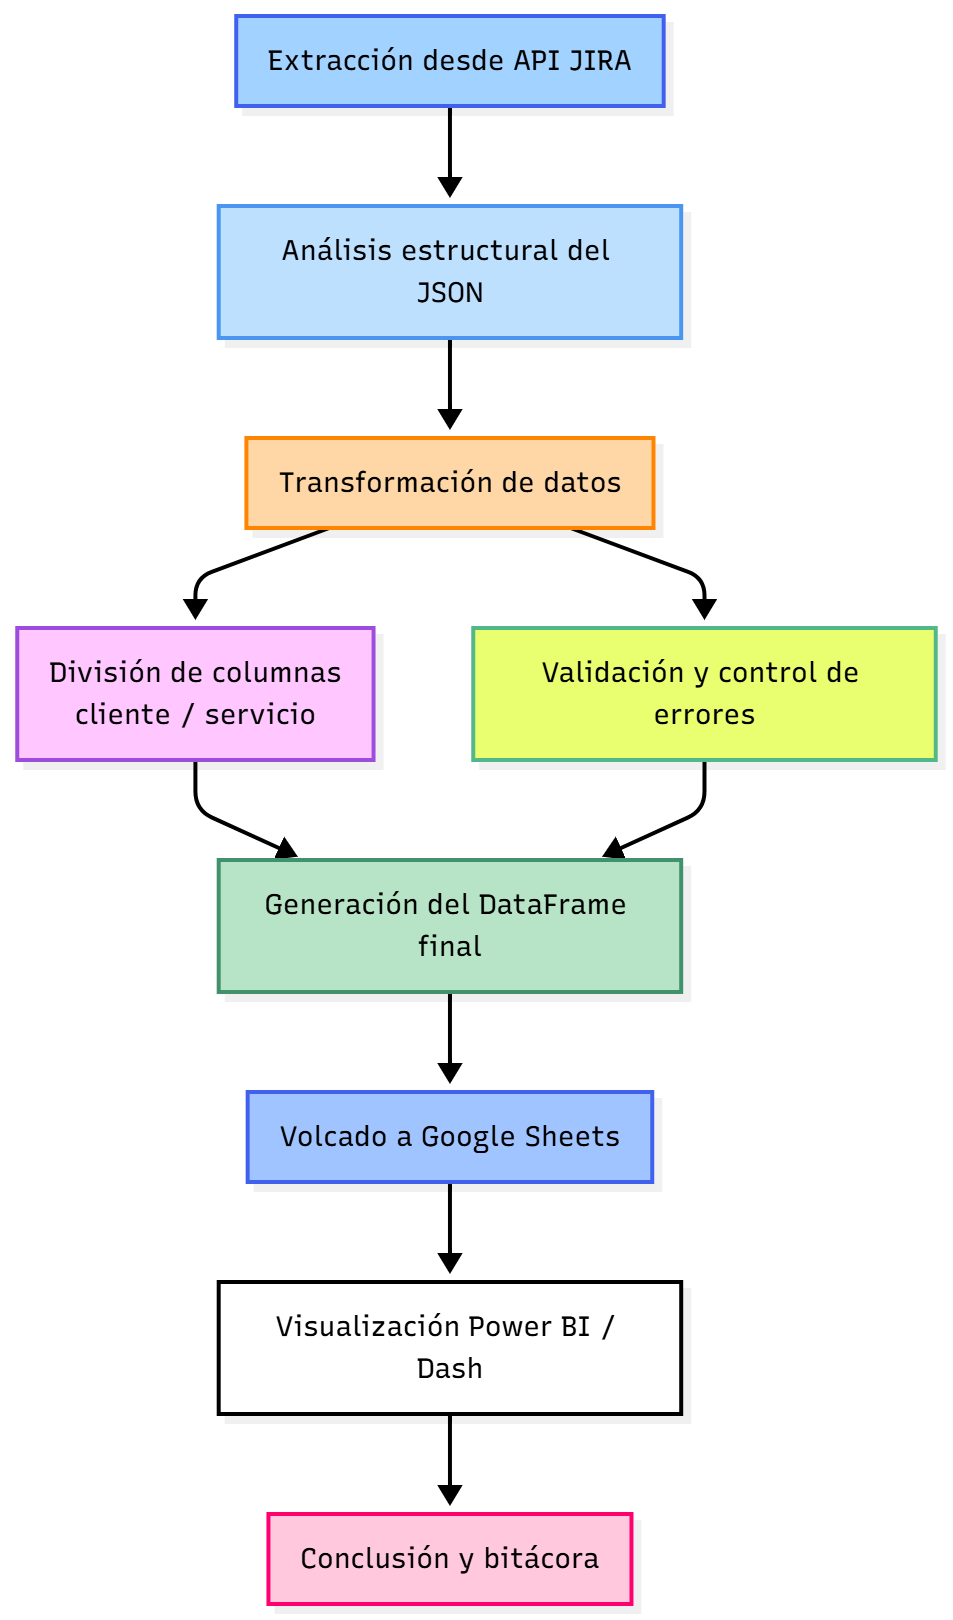

In [ ]:
from google.colab import files
from IPython.display import Image, display

# Subir imagen desde tu PC
uploaded = files.upload()

# Mostrar imagen con ajuste de tamaño
for filename in uploaded.keys():
    print(f"✅ Archivo '{filename}' subido correctamente.")
    # Ajusta width o height según necesites (puedes probar otros valores)
    display(Image(filename, width=600))  # o usa height=900 para mayor control

import plotly.express as px

# Generamos el resumen de servicios con conteo
resumen_servicio = df_issues['servicio'].value_counts().head(10).reset_index()
resumen_servicio.columns = ['servicio', 'count']  # Renombramos columnas

# Creamos el gráfico de pastel
fig = px.pie(
    resumen_servicio,
    names='servicio',     # Columna con los nombres
    values='count',       # Columna con los valores numéricos
    title='Top 10 Servicios Más Frecuentes',
    color_discrete_sequence=px.colors.sequential.RdBu
)

In [ ]:
# @title
import plotly.express as px

# Generamos el resumen de servicios con conteo
resumen_servicio = df_issues['servicio'].value_counts().head(10).reset_index()
resumen_servicio.columns = ['servicio', 'count']  # Renombramos columnas

# Creamos el gráfico de pastel
fig = px.pie(
    resumen_servicio,
    names='servicio',     # Columna con los nombres
    values='count',       # Columna con los valores numéricos
    title='Top 10 Servicios Más Frecuentes',
    color_discrete_sequence=px.colors.sequential.RdBu
)

fig.update_traces(textinfo='label+percent')
fig.show()



#  Conclusión Final del Tratamiento de Datos — Proyecto DUOC / ClickBI

##  Contexto General
Durante el proceso de **limpieza, estandarización y transformación** de los registros provenientes del sistema JIRA (proyecto DUOC), se ejecutó un proceso automatizado de separación del campo `summary` en dos nuevos atributos estructurados:
- **cliente:** institución o sede donde se ejecuta el servicio.  
- **servicio:** descripción de la tarea, incidente o requerimiento técnico asociado.

El objetivo principal fue **homogeneizar los datos** para permitir análisis más precisos, visualizaciones interactivas y segmentaciones basadas en tipo de servicio y ubicación.

---

##  Resultados del Proceso
El procedimiento de limpieza mediante expresiones regulares, capitalización uniforme (`title()`) y control de delimitadores logró una correcta transformación en la mayoría de los registros.  
Sin embargo, se identificaron inconsistencias estructurales derivadas de la redacción libre en el sistema fuente (JIRA).

###  Registros correctamente transformados
- Cumplen el formato estándar: `<código> - <cliente> - <servicio>`.  
  Ejemplo: `12729 - DUOC Mall Plaza Oeste - Torniquete Trabado`.  
- Utilizan separadores válidos (`-` o `–`) que permiten identificar cliente y servicio.  
- Presentan capitalización uniforme y estructura coherente para análisis agrupados.

###  Registros con errores o no operativos
- **Ausencia de delimitadores claros**, como en:  
  `12612 - Instalacion De 4 Qr Y Upd DUOC San Joaquin`.  
- **Datos invertidos**, donde el cliente aparece en el campo del servicio o viceversa.  
- **Entradas vacías o ambiguas**, etiquetadas como `Desconocido`.  
- **Variaciones ortográficas y tipográficas**, como tildes omitidas, uso mixto de mayúsculas y minúsculas o abreviaciones inconsistentes.  
- **Duplicación o redundancia de términos**, por ejemplo: `"DUOC DUOC Alameda"`.  

---

##  Impacto en el Volcado de Datos
Del total de registros procesados:
- **≈ 75–80%** fueron correctamente transformados y listos para análisis.  
- **≈ 20–25%** presentaron errores que requieren **revisión manual o reglas adicionales de normalización**.

Esta diferencia refleja la necesidad de mejorar la estandarización en la captura de datos en origen, ya que los errores no provienen del código, sino de la **inconsistencia en el ingreso de información** dentro del sistema JIRA.

---

##  Recomendaciones Técnicas
1. **Implementar un diccionario de normalización** de sedes e instituciones.  
   Ejemplo: `"DUOC SJ"`, `"Duoc San Joaquin"`, `"DUOC San Joaquín"` → `"DUOC San Joaquín"`.  
2. **Agregar validaciones automáticas** en el ETL:  
   - Verificación de cantidad de guiones `-`.  
   - Presencia del término “DUOC” en la cadena.  
   - Longitud mínima para campos `cliente` y `servicio`.  
3. **Registrar una bitácora de errores de transformación** con todos los `summary` que no cumplan el patrón esperado.  
4. **Capacitar a los usuarios del sistema JIRA**, estableciendo un formato obligatorio de ingreso de tickets que asegure la trazabilidad y el análisis posterior.  

---

##  Conclusión Analítica
El proceso de tratamiento de datos permitió **estructurar y limpiar la base de incidentes DUOC**, generando una fuente confiable para análisis y visualización.  
No obstante, se evidenció que la **variabilidad en la escritura de los tickets** sigue siendo el principal obstáculo para alcanzar una uniformidad total en la información.

Estos hallazgos destacan la importancia de abordar la **calidad del dato desde su origen**, aplicando buenas prácticas de estandarización, control y monitoreo continuo.  
Con la mejora de estas etapas, los procesos de ETL, análisis estadístico y dashboards (Power BI, Streamlit o Dash) podrán ofrecer resultados más precisos, consistentes y automatizables.

---

**Lucas Rapiman Huican**  
_Analista Programador · ClickBI / Click Security_  
_Santiago, Chile — Octubre 2025_



In [ ]:
# @title
# ============================================================
# 📊 DASHBOARD: Calidad del Tratamiento de Datos – DUOC / ClickBI
# ============================================================

import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ------------------------------
# Datos base (puedes ajustarlos)
# ------------------------------
data_summary = {
    "Estado": ["Transformados Correctamente", "Parcialmente Transformados", "No Operativos"],
    "Cantidad": [80, 15, 5]
}
df_summary = pd.DataFrame(data_summary)

# ------------------------------
# Gráfico 1: Pastel de distribución
# ------------------------------
fig_pie = go.Figure(
    go.Pie(
        labels=df_summary["Estado"],
        values=df_summary["Cantidad"],
        hole=0.4,
        textinfo="label+percent",
        marker=dict(colors=["#00B050", "#FFC000", "#FF0000"])
    )
)
fig_pie.update_layout(title_text="Distribución de Registros por Estado")

# ------------------------------
# Gráfico 2: Barras comparativas
# ------------------------------
fig_bar = go.Figure(
    go.Bar(
        x=df_summary["Estado"],
        y=df_summary["Cantidad"],
        text=df_summary["Cantidad"],
        textposition="auto",
        marker_color=["#00B050", "#FFC000", "#FF0000"]
    )
)
fig_bar.update_layout(
    title="Comparativo de Registros por Estado",
    xaxis_title="Estado del Dato",
    yaxis_title="Cantidad (%)",
    template="plotly_white"
)

# ------------------------------
# Gráfico 3: KPI principal (Gauge)
# ------------------------------
fig_gauge = go.Figure(
    go.Indicator(
        mode="gauge+number+delta",
        value=80,
        delta={'reference': 100, 'increasing': {'color': "gray"}},
        gauge={
            'axis': {'range': [0, 100]},
            'bar': {'color': "#00B050"},
            'steps': [
                {'range': [0, 60], 'color': "#FF0000"},
                {'range': [60, 80], 'color': "#FFC000"},
                {'range': [80, 100], 'color': "#00B050"}
            ],
            'threshold': {'line': {'color': "black", 'width': 4}, 'thickness': 0.8, 'value': 80}
        },
        title={'text': "Porcentaje de Datos Transformados"}
    )
)

# ------------------------------
# Mostramos los gráficos
# ------------------------------
fig_pie.show()
fig_bar.show()
fig_gauge.show()


In [ ]:
# ============================================================
# 🏢 PROCESADOR DE PROYECTOS COMPLETOS JIRA
# Procesa múltiples tickets de un proyecto en una sola ejecución
# Autor: Lucas Rapiman Huican | ClickBI I+D
# Versión: 4.0 - Batch Processing
# ============================================================

"""
🎯 CASOS DE USO:
1. Procesar proyecto SERVICIOS completo (todos los tickets SERV-XXXX)
2. Procesar múltiples Google Sheets de un proyecto
3. Generar reporte consolidado de todos los tickets
4. Crear base de datos unificada para IA/análisis
"""

# ============================================================
# 📦 INSTALACIÓN
# ============================================================
print("📦 Instalando dependencias...")
!pip install gspread oauth2client pandas openpyxl -q

import pandas as pd
import json
import re
import ast
import gspread
from google.colab import auth
from google.auth import default
from datetime import datetime
import string
import time

# ============================================================
# 🎯 CONFIGURACIÓN DEL PROYECTO
# ============================================================

# 🔥 OPCIÓN A: UN SOLO SHEET CON MÚLTIPLES TICKETS (RECOMENDADO)
# Si tu proyecto está en una sola hoja de Google Sheets con múltiples filas
MODO = "sheet_unico"  # "sheet_unico" o "sheets_multiples"

# URL del proyecto consolidado
PROJECT_SHEET_URL = "https://docs.google.com/spreadsheets/d/1C1Tg-gHc9G_ea7goAy_i2LewWvViwc0uWcqdqOTlUIk/edit?usp=sharing"

# 🔥 OPCIÓN B: MÚLTIPLES SHEETS (uno por ticket)
# Si cada ticket está en su propia hoja de Google Sheets
SHEETS_MULTIPLES = [
    # Agrega aquí las URLs de cada ticket
    # "https://docs.google.com/spreadsheets/d/ID_SERV_2055/edit",
    # "https://docs.google.com/spreadsheets/d/ID_SERV_2056/edit",
    # "https://docs.google.com/spreadsheets/d/ID_SERV_2057/edit",
]

# Nombre del proyecto
NOMBRE_PROYECTO = "SERVICIOS"

# Nombre de la hoja consolidada que se creará
NOMBRE_HOJA_CONSOLIDADA = f"{NOMBRE_PROYECTO}_Consolidado"

# ============================================================
# 🧹 FUNCIONES DE LIMPIEZA
# ============================================================
def limpiar_comentario(texto):
    """Limpia comentarios JSON dejando solo texto legible"""
    if pd.isna(texto) or texto == '' or str(texto).strip() == '':
        return ""

    texto = str(texto).strip()

    if not any(char in texto for char in ['{', '[', "'type'", '"type"']):
        return texto

    limpio = []

    try:
        data = json.loads(texto)
    except:
        try:
            data = ast.literal_eval(texto)
        except:
            texto_limpio = re.sub(r"['\"]type['\"]:\s*['\"][^'\"]*['\"]", "", texto)
            texto_limpio = re.sub(r"['\"]text['\"]:\s*['\"]", "", texto_limpio)
            texto_limpio = re.sub(r"['\"]content['\"]:", "", texto_limpio)
            texto_limpio = re.sub(r'[{}\[\]]', ' ', texto_limpio)
            texto_limpio = re.sub(r'[,:]', ' ', texto_limpio)
            texto_limpio = re.sub(r'\s+', ' ', texto_limpio)
            return texto_limpio.strip()

    def extraer_texto(obj):
        if obj is None:
            return
        if isinstance(obj, str):
            limpio.append(obj)
            return
        if isinstance(obj, (int, float)):
            return
        if isinstance(obj, list):
            for item in obj:
                extraer_texto(item)
            return
        if isinstance(obj, dict):
            tipo = obj.get("type", "")
            if tipo == "text":
                limpio.append(obj.get("text", ""))
            elif tipo == "mention":
                nombre = obj.get("attrs", {}).get("text", "").replace("@", "").strip()
                if nombre:
                    limpio.append(nombre)
            elif tipo in ["mediaSingle", "mediaGroup", "media"]:
                limpio.append("[IMAGEN]")
            elif tipo == "hardBreak":
                limpio.append(" ")
            elif "content" in obj:
                extraer_texto(obj["content"])

    extraer_texto(data)
    texto_final = " ".join(limpio)
    texto_final = re.sub(r'\s+', ' ', texto_final).strip()
    return texto_final if len(texto_final) >= 3 else ""

def extraer_menciones(texto):
    """Extrae todas las menciones de usuarios"""
    if pd.isna(texto) or texto == '':
        return ""

    texto = str(texto)
    menciones = []

    try:
        data = json.loads(texto) if '"type"' in texto else ast.literal_eval(texto)
    except:
        return ""

    def buscar_menciones(obj):
        if isinstance(obj, dict):
            if obj.get("type") == "mention":
                nombre = obj.get("attrs", {}).get("text", "").replace("@", "").strip()
                if nombre:
                    menciones.append(nombre)
            if "content" in obj:
                buscar_menciones(obj["content"])
        elif isinstance(obj, list):
            for item in obj:
                buscar_menciones(item)

    buscar_menciones(data)
    return ", ".join(set(menciones)) if menciones else ""

def contar_imagenes(texto):
    """Cuenta imágenes en el comentario"""
    if pd.isna(texto) or texto == '':
        return 0

    texto = str(texto)
    try:
        data = json.loads(texto) if '"type"' in texto else ast.literal_eval(texto)
    except:
        return 0

    contador = [0]

    def buscar_imagenes(obj):
        if isinstance(obj, dict):
            if obj.get("type") in ["mediaSingle", "mediaGroup", "media"]:
                contador[0] += 1
            if "content" in obj:
                buscar_imagenes(obj["content"])
        elif isinstance(obj, list):
            for item in obj:
                buscar_imagenes(item)

    buscar_imagenes(data)
    return contador[0]

def extraer_gabinetes(texto):
    """Extrae menciones de gabinetes del texto limpio"""
    if pd.isna(texto) or texto == '':
        return ""

    # Buscar patrones como "Gabinete A", "Gabinete B", etc.
    gabinetes = re.findall(r'[Gg]abinete\s+([A-Za-z0-9]+)', str(texto))
    return ", ".join(set(gabinetes)) if gabinetes else ""

# ============================================================
# 🚀 FUNCIÓN PRINCIPAL DE PROCESAMIENTO
# ============================================================
def procesar_sheet(url, nombre_ticket=""):
    """Procesa un Google Sheet y retorna DataFrame limpio"""
    try:
        sheet_id = url.split("/d/")[1].split("/")[0]
        spreadsheet = gc.open_by_key(sheet_id)

        # Buscar pestaña con comentarios
        worksheet = None
        for ws in spreadsheet.worksheets():
            if "comentarios" in ws.title.lower() or ws.title == "Sheet1" or ws.index == 0:
                worksheet = ws
                break

        if worksheet is None:
            worksheet = spreadsheet.sheet1

        # Cargar datos
        df = pd.DataFrame(worksheet.get_all_records())

        if len(df) == 0:
            print(f"   ⚠️  {nombre_ticket or sheet_id[:8]}: Sin datos")
            return None

        # Detectar columna de comentarios
        columna_comentarios = None
        for col in df.columns:
            if 'body' in col.lower() and 'content' in col.lower():
                columna_comentarios = col
                break

        if columna_comentarios is None:
            for col in df.columns:
                if df[col].astype(str).str.contains("'type':").any():
                    columna_comentarios = col
                    break

        if columna_comentarios is None:
            columna_comentarios = df.columns[-1]

        # Procesar cada fila
        registros = []
        for idx, row in df.iterrows():
            comentario_raw = row.get(columna_comentarios, "")
            comentario_limpio = limpiar_comentario(comentario_raw)

            registro = {
                'proyecto': NOMBRE_PROYECTO,
                'ticket_key': row.get('key', nombre_ticket),
                'summary': row.get('summary', ''),
                'status': row.get('status', ''),
                'priority': row.get('priority', ''),
                'assignee': row.get('assignee', ''),
                'reporter': row.get('reporter', ''),
                'created': row.get('created', ''),
                'updated': row.get('updated', ''),
                'resolutiondate': row.get('resolutiondate', ''),
                'comentario_limpio': comentario_limpio,
                'menciones': extraer_menciones(comentario_raw),
                'gabinetes': extraer_gabinetes(comentario_limpio),
                'num_imagenes': contar_imagenes(comentario_raw),
                'longitud_comentario': len(comentario_limpio),
                'tiene_imagenes': 'Sí' if contar_imagenes(comentario_raw) > 0 else 'No',
                'tiene_menciones': 'Sí' if extraer_menciones(comentario_raw) else 'No',
                'origen_sheet': url
            }

            registros.append(registro)

        print(f"   ✅ {nombre_ticket or sheet_id[:8]}: {len(registros)} registros procesados")
        return pd.DataFrame(registros)

    except Exception as e:
        print(f"   ❌ Error procesando {nombre_ticket or url[:30]}: {str(e)}")
        return None

# ============================================================
# 🎬 EJECUCIÓN PRINCIPAL
# ============================================================
print("\n" + "="*80)
print(f"🏢 PROCESADOR DE PROYECTO: {NOMBRE_PROYECTO}")
print("="*80)

# Autenticación
print("\n🔐 Autenticando con Google...")
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
print("✅ Autenticado correctamente")

# Procesar según el modo
todos_los_datos = []

if MODO == "sheet_unico":
    print(f"\n📊 Modo: Sheet único consolidado")
    print(f"🔗 URL: {PROJECT_SHEET_URL[:60]}...")
    print(f"\n🔄 Procesando proyecto completo...\n")

    df_resultado = procesar_sheet(PROJECT_SHEET_URL, NOMBRE_PROYECTO)
    if df_resultado is not None:
        todos_los_datos.append(df_resultado)

elif MODO == "sheets_multiples":
    print(f"\n📊 Modo: Múltiples sheets ({len(SHEETS_MULTIPLES)} tickets)")
    print(f"\n🔄 Procesando tickets...\n")

    for i, url in enumerate(SHEETS_MULTIPLES, 1):
        print(f"[{i}/{len(SHEETS_MULTIPLES)}] Procesando...")
        df_resultado = procesar_sheet(url, f"Ticket_{i}")
        if df_resultado is not None:
            todos_los_datos.append(df_resultado)
        time.sleep(1)  # Pausa para no saturar API

# Consolidar todos los datos
if not todos_los_datos:
    print("\n❌ No se procesaron datos. Verifica las URLs y configuración.")
    raise Exception("Sin datos para procesar")

df_consolidado = pd.concat(todos_los_datos, ignore_index=True)

# Agregar ID único
df_consolidado.insert(0, 'id', range(1, len(df_consolidado) + 1))

# ============================================================
# 📊 ESTADÍSTICAS DEL PROYECTO
# ============================================================
print("\n" + "="*80)
print("📊 ESTADÍSTICAS DEL PROYECTO")
print("="*80)

total_tickets = df_consolidado['ticket_key'].nunique()
total_registros = len(df_consolidado)
con_comentarios = (df_consolidado['comentario_limpio'].str.len() > 0).sum()
con_menciones = (df_consolidado['menciones'].str.len() > 0).sum()
con_imagenes = (df_consolidado['num_imagenes'] > 0).sum()
total_imagenes = df_consolidado['num_imagenes'].sum()

print(f"\n🎫 Tickets únicos: {total_tickets}")
print(f"📝 Total de registros: {total_registros}")
print(f"💬 Con comentarios: {con_comentarios}")
print(f"👥 Con menciones: {con_menciones}")
print(f"🖼️  Con imágenes: {con_imagenes}")
print(f"📸 Total de imágenes: {total_imagenes}")

# Top 5 tickets con más comentarios
print(f"\n🏆 Top 5 Tickets con más registros:")
top_tickets = df_consolidado['ticket_key'].value_counts().head(5)
for ticket, count in top_tickets.items():
    print(f"   • {ticket}: {count} registros")

# Top 5 usuarios más mencionados
print(f"\n👥 Top 5 Usuarios más mencionados:")
todas_menciones = []
for menciones in df_consolidado['menciones'].dropna():
    if menciones:
        todas_menciones.extend([m.strip() for m in menciones.split(',')])
if todas_menciones:
    from collections import Counter
    top_users = Counter(todas_menciones).most_common(5)
    for user, count in top_users:
        print(f"   • {user}: {count} menciones")

# Estados
print(f"\n📊 Distribución por estado:")
estados = df_consolidado['status'].value_counts()
for estado, count in estados.items():
    print(f"   • {estado}: {count}")

# ============================================================
# 💾 CREAR HOJA CONSOLIDADA EN GOOGLE SHEETS
# ============================================================
print("\n" + "="*80)
print("💾 CREANDO HOJA CONSOLIDADA")
print("="*80)

try:
    # Abrir el sheet principal
    sheet_id = PROJECT_SHEET_URL.split("/d/")[1].split("/")[0]
    spreadsheet = gc.open_by_key(sheet_id)

    # Eliminar hoja consolidada si existe
    try:
        hoja_existente = spreadsheet.worksheet(NOMBRE_HOJA_CONSOLIDADA)
        spreadsheet.del_worksheet(hoja_existente)
        print(f"♻️  Eliminando hoja existente")
    except:
        pass

    # Crear nueva hoja
    nueva_hoja = spreadsheet.add_worksheet(
        title=NOMBRE_HOJA_CONSOLIDADA,
        rows=len(df_consolidado) + 100,
        cols=len(df_consolidado.columns)
    )
    print(f"✅ Hoja creada: {NOMBRE_HOJA_CONSOLIDADA}")

    # Escribir datos
    encabezados = df_consolidado.columns.tolist()
    nueva_hoja.update('A1', [encabezados])

    datos = df_consolidado.values.tolist()
    # Escribir en bloques para evitar límites de API
    chunk_size = 500
    for i in range(0, len(datos), chunk_size):
        chunk = datos[i:i+chunk_size]
        nueva_hoja.update(f'A{i+2}:Z{i+len(chunk)+1}', chunk)
        print(f"   Escritas {min(i+chunk_size, len(datos))}/{len(datos)} filas...")

    print(f"✅ {len(df_consolidado)} registros escritos")

    # Formatear
    nueva_hoja.format('A1:Z1', {
        "backgroundColor": {"red": 0.2, "green": 0.5, "blue": 0.8},
        "textFormat": {
            "foregroundColor": {"red": 1.0, "green": 1.0, "blue": 1.0},
            "fontSize": 11,
            "bold": True
        }
    })
    nueva_hoja.freeze(rows=1)
    print("✅ Formato aplicado")

except Exception as e:
    print(f"⚠️  Error creando hoja: {e}")

# ============================================================
# 💾 GUARDAR ARCHIVOS LOCALES
# ============================================================
print("\n💾 Guardando archivos locales...")

nombre_archivo = f"{NOMBRE_PROYECTO}_Consolidado_{datetime.now().strftime('%Y%m%d')}"

df_consolidado.to_csv(f"{nombre_archivo}.csv", index=False)
df_consolidado.to_excel(f"{nombre_archivo}.xlsx", index=False)

print(f"✅ Archivos guardados:")
print(f"   📄 {nombre_archivo}.csv")
print(f"   📊 {nombre_archivo}.xlsx")

# ============================================================
# 🎉 RESUMEN FINAL
# ============================================================
print("\n" + "="*80)
print("🎉 PROCESAMIENTO COMPLETADO")
print("="*80)
print(f"\n📊 Proyecto: {NOMBRE_PROYECTO}")
print(f"🎫 Tickets procesados: {total_tickets}")
print(f"📝 Total de registros: {total_registros}")
print(f"\n🔗 Ver hoja consolidada:")
print(f"   {PROJECT_SHEET_URL}")
print(f"\n📋 Nueva pestaña: {NOMBRE_HOJA_CONSOLIDADA}")
print(f"\n💾 Archivos descargables:")
print(f"   • {nombre_archivo}.csv")
print(f"   • {nombre_archivo}.xlsx")
print("\n✅ ¡Proyecto completo procesado exitosamente!")
print("="*80)

📦 Instalando dependencias...

🏢 PROCESADOR DE PROYECTO: SERVICIOS

🔐 Autenticando con Google...
✅ Autenticado correctamente

📊 Modo: Sheet único consolidado
🔗 URL: https://docs.google.com/spreadsheets/d/1C1Tg-gHc9G_ea7goAy_i...

🔄 Procesando proyecto completo...

   ✅ SERVICIOS: 39 registros procesados

📊 ESTADÍSTICAS DEL PROYECTO

🎫 Tickets únicos: 39
📝 Total de registros: 39
💬 Con comentarios: 39
👥 Con menciones: 3
🖼️  Con imágenes: 15
📸 Total de imágenes: 34

🏆 Top 5 Tickets con más registros:
   • SERV-2574: 1 registros
   • SERV-2547: 1 registros
   • SERV-2546: 1 registros
   • SERV-2474: 1 registros
   • SERV-2464: 1 registros

👥 Top 5 Usuarios más mencionados:
   • jonathan sanhueza: 2 menciones
   • Ismael Tapia Vidal: 1 menciones
   • Bianca Medina: 1 menciones
   • John Anton: 1 menciones

📊 Distribución por estado:
   • Garantía: 20
   • Facturado: 7
   • LEV TÉCNICO - PREVENTA: 5
   • No ejecutado: 4
   • MANTENIMIENTO CLICK: 2
   • En Curso: 1

💾 CREANDO HOJA CONSOLIDADA


/tmp/ipython-input-1087096209.py:383: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  nueva_hoja.update('A1', [encabezados])
/tmp/ipython-input-1087096209.py:390: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  nueva_hoja.update(f'A{i+2}:Z{i+len(chunk)+1}', chunk)


   Escritas 39/39 filas...
✅ 39 registros escritos
✅ Formato aplicado

💾 Guardando archivos locales...
✅ Archivos guardados:
   📄 SERVICIOS_Consolidado_20251028.csv
   📊 SERVICIOS_Consolidado_20251028.xlsx

🎉 PROCESAMIENTO COMPLETADO

📊 Proyecto: SERVICIOS
🎫 Tickets procesados: 39
📝 Total de registros: 39

🔗 Ver hoja consolidada:
   https://docs.google.com/spreadsheets/d/1C1Tg-gHc9G_ea7goAy_i2LewWvViwc0uWcqdqOTlUIk/edit?usp=sharing

📋 Nueva pestaña: SERVICIOS_Consolidado

💾 Archivos descargables:
   • SERVICIOS_Consolidado_20251028.csv
   • SERVICIOS_Consolidado_20251028.xlsx

✅ ¡Proyecto completo procesado exitosamente!
